In [1]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from file_paths_and_consts import *
import os
import geopandas as gpd
import pandas as pd
import json
import sys
import argparse
import warnings
import pickle
import properscoring as ps
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

## HELPER Functions

In [2]:
warnings.filterwarnings('ignore')

def get_refugee_file(raion_name,sim_idx):
    refugee_file_name = f'mim_hid_completed_{raion_name}_{sim_idx}.csv'
    refugee_file_name_fast = f'mim_hid_completed_{raion_name}_{sim_idx}.pq'
    hid_status_file = OUTPUT_DIR+refugee_file_name
    hid_status_file_fast = OUTPUT_DIR+refugee_file_name_fast
    if os.path.isfile(hid_status_file_fast):
        df_hid = pd.read_parquet(hid_status_file_fast)
    else:
        df_hid = pd.read_csv(hid_status_file)
        df_hid.to_parquet(hid_status_file_fast,index=False)
    df_hid = df_hid[['hid','prob_conflict','OLD_PERSON','CHILD','ADULT_MALE','ADULT_FEMALE','rlid','h_lat','h_lng',
                     'N_size','P(move|violence)','moves','move_type','move_date']]
    df_refugee = df_hid[df_hid.move_type==2]
    #print(df_hid.shape[0],'displaced from MIM simulation')
    #print(df_refugee.shape[0],'refugees from MIM simulation')
    return df_refugee

def assign_destination(df_refugee,raion_to_dest_df,raion_name):
    sci_country_code = ['HU','MDA','PL','RO','SK','BLR']
    dest_factors = ['weight_sci','weight_nato','weight_gdp','weight_gdp_per_capita','weight_dis']
    country_3_code = ['HUN','MDA','POL','ROU','SVK','BLR']
    default_raion = raion_to_dest_df['ADM2_EN'].tolist()[0]
    if raion_name in raion_to_dest_df['ADM2_EN'].tolist():
        #print(raion_name,'contains a prob distribution')
        dest_pdf = raion_to_dest_df[raion_to_dest_df.ADM2_EN==raion_name]
        #default_pdf['normalized_weight'] = 1.0/len(sci_country_code)
    else:
        #print(raion_name,'does not exist, loading uniform distribution')
        dest_pdf = raion_to_dest_df[raion_to_dest_df.ADM2_EN==default_raion]
        dest_pdf['normalized_weight'] = 1.0/len(sci_country_code)
        
    dest_list = (dest_pdf.sample(df_refugee.shape[0],random_state=42,replace=True,weights=dest_pdf['normalized_weight'])['dest']).tolist()
    df_refugee['dest'] = dest_list
    return df_refugee

def get_refugee_by_dest_agg(df_refugee,raion_name,dest='PL'):
    df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
    df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
    aggdf_refugee_dest = df_refugee[df_refugee.dest=='PL'].groupby('move_date')['h_size'].sum().reset_index()
    return aggdf_refugee_dest

def insiderange(x,val1,val2):
    return (x>=val1 and x<=val2)

def apply_footprint(h_row,footprint):
    val1 = insiderange(h_row['OLD_PERSON'],footprint[0][0],footprint[0][1])
    val2 = insiderange(h_row['CHILD'],footprint[1][0],footprint[1][1])
    val3 = insiderange(h_row['ADULT_MALE'],footprint[2][0],footprint[2][1])
    val4 = insiderange(h_row['ADULT_FEMALE'],footprint[3][0],footprint[3][1])
    return val1 and val2 and val3 and val4

def get_refugee_by_household_category_agg(df_refugee,raion_name,dest='PL'):
    footprints = [[(0,0),(0,0),(1,1),(0,0)],[(0,0),(0,0),(0,0),(1,1)],
                  [(0,0),(0,0),(2,100),(0,0)],[(0,0),(0,0),(0,0),(2,100)],
                  [(1,100),(0,0),(0,100),(0,100)],[(0,0),(1,100),(0,100),(0,100)],
                  [(1,100),(1,100),(0,100),(0,100)],[(0,0),(0,0),(1,100),(1,100)]]
    groups = ['single_male','single_female','male_only','female_only',
              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']
    
    for idx,g in enumerate(groups):
        df_refugee[g] = df_refugee.apply(lambda x: apply_footprint(x,footprints[idx]),axis=1)
    #return df_refugee
    df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
    df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
    
    agg_df = (df_refugee[(df_refugee.dest==dest)].groupby('move_date')['h_size'].sum().reset_index())
    
    for idx,g in enumerate(groups):
        cur_demo_agg_df = (df_refugee[(df_refugee.dest==dest) & 
                                      (df_refugee[g]==True)].groupby('move_date')['h_size'].sum().reset_index()).rename(columns={'h_size':g})
        agg_df = agg_df.merge(cur_demo_agg_df,on='move_date',how='left').fillna(0)
    
    return agg_df

def get_refugee_by_household_category6_agg(df_refugee,raion_name,dest='PL'):
    footprints = [[(0,0),(0,0),(1,100),(0,0)],[(0,0),(0,0),(0,0),(1,100)],
                  [(1,100),(0,0),(0,100),(0,100)],[(0,0),(1,100),(0,100),(0,100)],
                  [(1,100),(1,100),(0,100),(0,100)],[(0,0),(0,0),(1,100),(1,100)]]
    groups = ['male_only','female_only',
              'elderly_no_child','child_no_elderly',
              'child_and_elderly','just_couples']
    
    for idx,g in enumerate(groups):
        df_refugee[g] = df_refugee.apply(lambda x: apply_footprint(x,footprints[idx]),axis=1)
    #return df_refugee
    df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
    df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
    
    agg_df = (df_refugee[(df_refugee.dest==dest)].groupby('move_date')['h_size'].sum().reset_index())
    
    for idx,g in enumerate(groups):
        cur_demo_agg_df = (df_refugee[(df_refugee.dest==dest) & 
                                      (df_refugee[g]==True)].groupby('move_date')['h_size'].sum().reset_index()).rename(columns={'h_size':g})
        agg_df = agg_df.merge(cur_demo_agg_df,on='move_date',how='left').fillna(0)
    
    return agg_df

def compute_loss(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    mse = (((merged_df['Total']-merged_df[observe_col])**2).sum())/merged_df.shape[0]
    corr = merged_df['Total'].corr(merged_df[observe_col], method='pearson')
    rmse = mse**0.5
    nrmse = rmse/(max(merged_df[observe_col])-min(merged_df[observe_col]))
    print(nrmse,corr)
    if corr<0:
        #return max(merged_df[observe_col])*10
        nrmse = 2
    return 0.2*(1-corr)+0.8*nrmse
    #return merged_df, corr,nrmse

In [3]:
geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
ukr_gdf = gpd.read_file(geo_shp_file)
all_raions = ukr_gdf['ADM2_EN'].tolist()
print('regions read..',flush=True)

regions read..


ERROR 1: PROJ: proj_create_from_database: Open of /home/zm8bh/.conda/envs/migration_env/share/proj failed


## poland data

In [4]:
## reading ground truth data

## poland gt data
pl_border_data = pd.read_csv('poland_border_movement_utf8.csv',thousands=',')
#ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset=['Total'])
pl_border_data['Date'] = pd.to_datetime(pl_border_data['Date'])
ukr_people_arrive_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Arrival to Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.sort_values(by='Date')
ukr_people_depart_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Departure from Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.sort_values(by='Date')
ukr_people_arrive_poland_by_date['Total'] = ukr_people_arrive_poland_by_date['Total'].rolling(15).mean()
ukr_people_depart_poland_by_date['Total'] = ukr_people_depart_poland_by_date['Total'].rolling(15).mean()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset='Total')
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.dropna(subset='Total')
ukr_people_arrive_poland_by_date =  ukr_people_arrive_poland_by_date.rename(columns={'Date':'return_date','Total':'arrival'})
ukr_people_depart_poland_by_date =  ukr_people_depart_poland_by_date.rename(columns={'Date':'return_date','Total':'departure'})

## ARIMA on poland return data

In [5]:
# # Fit auto_arima function to ukr_poland_return  dataset 
# stepwise_fit = auto_arima(ukr_people_depart_poland_by_date['departure'], start_p = 1, start_q = 1, 
#                           max_p = 3, max_q = 3, m = 12, 
#                           start_P = 0, seasonal = True, 
#                           d = None, D = 1, trace = True, 
#                           error_action ='ignore',   # we don't want to know if an order does not work 
#                           suppress_warnings = True,  # we don't want convergence warnings 
#                           stepwise = True)           # set to stepwise 
  
# # To print the summary 
# stepwise_fit.summary() 

In [6]:

# # Split data into train / test sets 
# train = airline.iloc[:len(airline)-12] 
# test = airline.iloc[len(airline)-12:] # set one year(12 months) for testing 
  
# # Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
# from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
# model = SARIMAX(train['# Passengers'],  
#                 order = (0, 1, 1),  
#                 seasonal_order =(2, 1, 1, 12)) 
  
# result = model.fit() 
# result.summary() 


## slovak data

In [7]:
import json

with open('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/slovak_border_movement.json', 'r') as file:
    data = json.load(file)

# Print the data
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(15).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()
svk_ukr_depart_df = svk_ukr_depart_df.rename(columns={'data_date':'return_date','individuals':'departure'})

## dest prob distribution

In [8]:
raion_to_dest_df = pd.read_csv('from_raion_to_dest_refugee_pdf.csv')

## loading intention ensembles for return simulation

In [9]:
def load_intention_destination_df(raion_to_dest_df,all_raions,dest='PL'):
    good_sims = [5,6,7,9,11,12,14,19,21,23,26,29,39,40,43,45,46,48,49,50,51,53,54,63,67,78,86,87,98]
    #good_sims = [5]
    intention_sim = []

    dest_int = dest

    for sim in good_sims:
        #print(sim)

        cache_data = f'{CACHE_DIR}agg_intention_from_UKR_to_{dest_int}_sim_{str(sim).zfill(9)}.pq'

        if os.path.isfile(cache_data):
            intention_sim.append(pd.read_parquet(cache_data))
            continue

        all_dfs = []

        for raion in all_raions:
            #if raion!='Kyiv':
            #    continue
            #if raion=='Kyiv':
                #print(len(all_dfs))
            #print(raion)
            try:
                df_refugee = get_refugee_file(raion,str(sim).zfill(9))
            except:
                #print(raion,'intention was not simulated')
                continue
            df_refugee_with_dest = assign_destination(df_refugee,raion_to_dest_df,raion)
            agg_df_refugee = get_refugee_by_dest_agg(df_refugee_with_dest,raion)
            all_dfs.append(agg_df_refugee)
        #return all_dfs
        int_df = (pd.concat(all_dfs)).groupby('move_date')['h_size'].sum().reset_index()
        intention_sim.append(int_df)
        int_df.to_parquet(cache_data,index=False)
    return intention_sim

intention_sim = load_intention_destination_df(raion_to_dest_df,all_raions)

In [10]:
len(intention_sim)

29

In [11]:
%%time

def load_intention_destination_df_by_demo_category(raion_to_dest_df,all_raions,dest='PL'):
    good_sims = [5,6,7,9,11,12,14,19,21,23,26,29,39,40,43,45,46,48,49,50,51,53,54,63,67,78,86,87,98]
    #good_sims = [5]
    intention_sim = []

    dest_int = dest

    for sim in good_sims:
        print(sim)

        cache_data = f'{CACHE_DIR}demo_aggv4_intention_from_UKR_to_{dest_int}_sim_{str(sim).zfill(9)}.pq'

        if os.path.isfile(cache_data):
            intention_sim.append(pd.read_parquet(cache_data))
            continue

        groups = ['single_male','single_female','male_only','female_only',
              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']
        all_dfs = []
        for raion in all_raions:
            #print(raion)
            #if raion!='Kyiv':
            #    continue
                #print(len(all_dfs))
            #print(raion)
            try:
                df_refugee = get_refugee_file(raion,str(sim).zfill(9))
            except:
                #print(raion,'intention was not simulated')
                continue
            df_refugee_with_dest = assign_destination(df_refugee,raion_to_dest_df,raion)
            agg_df_refugee = get_refugee_by_household_category_agg(df_refugee_with_dest,raion)
            #agg_df_refugee['matched'] =  agg_df_refugee[groups].sum(axis=1)
            all_dfs.append(agg_df_refugee)
            #break
            #if agg_df_refugee[agg_df_refugee.matched>1].shape[0]>0:
            #    break
        #return all_dfs
        int_df = (pd.concat(all_dfs)).groupby('move_date')[['h_size']+groups].sum().reset_index()
        intention_sim.append(int_df)
        int_df.to_parquet(cache_data,index=False)
    return intention_sim

def load_intention_destination_df_by_demo_category6(raion_to_dest_df,all_raions,dest='PL'):
    good_sims = [5,6,7,9,11,12,14,19,21,23,26,29,39,40,43,45,46,48,49,50,51,53,54,63,67,78,86,87,98]
    #good_sims = [5]
    intention_sim = []

    dest_int = dest

    for sim in good_sims:
        print(sim)

        cache_data = f'{CACHE_DIR}demo_cat6_aggv1_intention_from_UKR_to_{dest_int}_sim_{str(sim).zfill(9)}.pq'

        if os.path.isfile(cache_data):
            intention_sim.append(pd.read_parquet(cache_data))
            continue

        groups = ['male_only','female_only',
              'elderly_no_child','child_no_elderly',
              'child_and_elderly','just_couples']
        all_dfs = []
        for raion in all_raions:
            #print(raion)
            #if raion!='Kyiv':
            #    continue
                #print(len(all_dfs))
            #print(raion)
            try:
                df_refugee = get_refugee_file(raion,str(sim).zfill(9))
            except:
                #print(raion,'intention was not simulated')
                continue
            df_refugee_with_dest = assign_destination(df_refugee,raion_to_dest_df,raion)
            agg_df_refugee = get_refugee_by_household_category6_agg(df_refugee_with_dest,raion)
            #agg_df_refugee['matched'] =  agg_df_refugee[groups].sum(axis=1)
            all_dfs.append(agg_df_refugee)
            #break
            #if agg_df_refugee[agg_df_refugee.matched>1].shape[0]>0:
            #    break
        #return all_dfs
        int_df = (pd.concat(all_dfs)).groupby('move_date')[['h_size']+groups].sum().reset_index()
        intention_sim.append(int_df)
        int_df.to_parquet(cache_data,index=False)
    return intention_sim

intention_sim_demo6 = load_intention_destination_df_by_demo_category6(raion_to_dest_df,all_raions)

5
6
7
9
11
12
14
19
21
23
26
29
39
40
43
45
46
48
49
50
51
53
54
63
67
78
86
87
98
CPU times: user 39 ms, sys: 5.71 ms, total: 44.7 ms
Wall time: 61.4 ms


In [12]:
# intention_sim_demo6['elderly_and_or_child'] = intention_sim_demo6['elderly_no_child']+intention_sim_demo6['child_no_elderly']+intention_sim_demo6['child_and_elderly']



In [13]:
# intention_sim_demo6

## helper functions for surrogate models

In [14]:
%%time

from skopt import Optimizer

def get_conflict_data(ROLL,LAG):
    USE_NEIGHBOR = 5
    CONFLICT_DATA_PREFIX = 'ukraine_conflict_data_ADM2_HDX_buffer_'
    NEIGHBOR_DATA_PREFIX = 'ukraine_neighbor_'
    NETWORK_TYPE = '_R_0.01_P_0.04_Q_8_al_2.3.csv'
    NETWORK_TYPE_fast = '_R_0.01_P_0.04_Q_8_al_2.3.pq'
    
    total_impact_data = pd.read_csv(IMPACT_DIR+CONFLICT_DATA_PREFIX+str(USE_NEIGHBOR)+'_km.csv')
    total_impact_data['time'] = pd.to_datetime(total_impact_data['time'])

    conflict_context = total_impact_data.groupby('time')['event_intensity'].sum().reset_index()
    conflict_context = conflict_context.rename(columns={'event_intensity':'conflict'})

    conflict_context['conflict'] = conflict_context['conflict'].rolling(ROLL).mean()
    conflict_context = conflict_context.dropna(subset='conflict')
    NORM_CONSTANT = conflict_context['conflict'].max()
    conflict_context['conflict'] = conflict_context['conflict']/NORM_CONSTANT

    conflict_context['conflict'] = conflict_context['conflict'].shift(LAG)
    conflict_context = conflict_context.dropna(subset='conflict')

    conflict_context = conflict_context.rename(columns={'time':'move_date'})
    return conflict_context

def surrogate_conflict_haz(intention_sim_df,h,lag,roll,not_print_flag=0):
    if not not_print_flag:
        print('running surrogate conflict model with hazard',h,'lag',lag,'roll',roll)
    conflict_context = get_conflict_data(roll,lag)
    intention_conflict_sim_df = intention_sim_df.merge(conflict_context,on='move_date',how='left').fillna(0)
    M = intention_conflict_sim_df['h_size'].tolist() ## M(t): remaining migrants at time t
    C = intention_conflict_sim_df['conflict'].tolist() ## C(t): conflict context observed at time t
    R = []
    for sim in range(0,len(M)):
        R.append(0)
    for sim in range(0,len(M)):
        S = 1.0
        past_sim = sim
        while(past_sim>=0): ## people who migrated prior to this can return at current time
            #print('past sim:',past_sim)
            Returnee = M[past_sim]-M[past_sim]*S
            R[sim] = R[sim] + Returnee
            M[past_sim] = M[past_sim] - Returnee
            S = S*(1.0-h*(1-C[past_sim]))
            past_sim = past_sim - 1
    
    return_df = intention_sim_df.copy(deep=True)
    return_df['returnee'] = pd.Series(R)
    return return_df

def surrogate_conflict_haz_with_peer(intention_sim_df,h_up,h_down,thresh,lag,roll,not_print_flag=0):
    if not not_print_flag:
        print('running surrogate peer conflict model with hazard',h_up,'above',thresh,'peer and',h_down,'before peer with lag',lag,'roll',roll)
    conflict_context = get_conflict_data(roll,lag)
    intention_conflict_sim_df = intention_sim_df.merge(conflict_context,on='move_date',how='left').fillna(0)
    M = intention_conflict_sim_df['h_size'].tolist() ## M(t): remaining migrants at time t
    C = intention_conflict_sim_df['conflict'].tolist() ## C(t): conflict context observed at time t
    R = []
    for sim in range(0,len(M)):
        R.append(0)
    tot_migrant = sum(M)
    cur_ret = 0.0
    for sim in range(0,len(M)):
        S = 1.0
        past_sim = sim
        peer_influence = cur_ret/tot_migrant
        if not not_print_flag:
            print('current peer pressure at sim time',sim,'is',peer_influence)
        h = h_up if (peer_influence)>=thresh else h_down
        while(past_sim>=0): ## people who migrated prior to this can return at current time
            #print('past sim:',past_sim)
            Returnee = M[past_sim]-M[past_sim]*S
            R[sim] = R[sim] + Returnee
            M[past_sim] = M[past_sim] - Returnee
            S = S*(1.0-h*(1-C[past_sim]))
            past_sim = past_sim - 1
        cur_ret = cur_ret + R[sim]
    return_df = intention_sim_df.copy(deep=True)
    return_df['returnee'] = pd.Series(R)
    return return_df

def surrogate_constant_haz(intention_sim_df,h,group_col='h_size',not_print_flag=0):
    if not not_print_flag:
        print('running surrogate model with hazard',h)
    M = intention_sim_df[group_col].tolist()
    R = []
    for sim in range(0,len(M)):
        R.append(0)
    for sim in range(0,len(M)):
        #print('sim:',sim)
        S = 1.0
        #R.append(0)
        past_sim = sim
        while(past_sim>=0):
            #print('past sim:',past_sim)
            Returnee = M[past_sim]-M[past_sim]*S
            R[sim] = R[sim] + Returnee
            M[past_sim] = M[past_sim] - Returnee
            S = S*(1.0-h)
            past_sim = past_sim - 1
            
    return_df = intention_sim_df.copy(deep=True)
    return_df['returnee'] = pd.Series(R)
    return return_df

def get_estimation_with_uncertainty(all_dfs,Q1=0.2,Q3=0.8,cache_clean_mode=0):
    return_ensemble_df = pd.concat(all_dfs)
    median_df = return_ensemble_df.groupby('move_date')['returnee'].quantile(q=0.5).reset_index()
    q1_df = (return_ensemble_df.groupby('move_date')['returnee'].quantile(q=Q1).reset_index()).rename(columns={'returnee':'q1'})
    q3_df = (return_ensemble_df.groupby('move_date')['returnee'].quantile(q=Q3).reset_index()).rename(columns={'returnee':'q3'})
    return_uncertain_df = (median_df.merge(q1_df,on='move_date',how='inner')).merge(q3_df,on='move_date',how='inner')
    return_uncertain_df = return_uncertain_df.rename(columns={'move_date':'return_date'})
    return return_uncertain_df

def get_estimation_with_uncertainty2(all_dfs,std_dev=2):
    return_ensemble_df = pd.concat(all_dfs)
    mean_df = return_ensemble_df.groupby('move_date')['returnee'].mean().reset_index()
    std_df = (return_ensemble_df.groupby('move_date')['returnee'].std().reset_index()).rename(columns={'returnee':'std'})
    return_uncertain_df = (mean_df.merge(std_df,on='move_date',how='inner'))
    return_uncertain_df['q1'] = return_uncertain_df['returnee']-return_uncertain_df['std']*std_dev
    return_uncertain_df['q3'] = return_uncertain_df['returnee']+return_uncertain_df['std']*std_dev
    return_uncertain_df = return_uncertain_df.rename(columns={'move_date':'return_date'})
    return return_uncertain_df

def compute_loss(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0,print_flag=1):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    mse = (((merged_df['returnee']-merged_df[observe_col])**2).sum())/merged_df.shape[0]
    corr = merged_df['returnee'].corr(merged_df[observe_col], method='pearson')
    rmse = mse**0.5
    nrmse = rmse/(max(merged_df[observe_col])-min(merged_df[observe_col]))
    if print_flag==1:
        print(nrmse,corr)    
    if corr<0:
        nrmse = 2
    return 0.2*(1-corr)+0.8*nrmse,nrmse,corr

def compute_loss2(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0,print_flag=1):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    mse = (((merged_df['returnee']-merged_df[observe_col])**2).sum())/merged_df.shape[0]
    corr = merged_df['returnee'].corr(merged_df[observe_col], method='pearson')
    rmse = mse**0.5
    nrmse = rmse/(max(merged_df[observe_col])-min(merged_df[observe_col]))
    return nrmse

def get_crps(all_sim_df,observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0):
    merged_df = all_sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    y = merged_df.iloc[:,-1].values
    crps_en = ps.crps_ensemble(merged_df.iloc[:,-1].values,merged_df.iloc[:,1:-1].values)
    crps = crps_en.sum()/np.sum(np.absolute(y))
    return crps

def estimate_blackbox_function_loss(intention_sim,func,other_args,date_start='2022-04-01',date_end='2022-08-01',no_print=0,q1=0.2,q3=0.8):    
    all_ret_df = []

    for idx,int_df in enumerate(intention_sim):
        ret_df = func(int_df,*other_args,not_print_flag=max(idx,no_print))
        ret_df['sim'] = str(idx)
        all_ret_df.append(ret_df)
    #print(all_ret_df[0].columns.tolist())
    crps = 0
    pivoted_df = (pd.concat(all_ret_df)).pivot(index='move_date',columns='sim',values='returnee').reset_index().rename(columns={'move_date':'return_date'})
    if not no_print:
        crps = get_crps(pivoted_df,ukr_people_depart_poland_by_date,'departure',date_start,date_end)
    final_ret_df = get_estimation_with_uncertainty(all_ret_df,Q1=q1,Q3=q3)
    ll,nrmse,corr = compute_loss(final_ret_df, ukr_people_depart_poland_by_date, 'departure', date_start, date_end,print_flag=1-no_print)
    print('nrmse',nrmse,'corr',corr,'loss',ll)
    #final_ret_df = get_estimation_with_uncertainty2(all_ret_df,std_dev=1)
    #ll = compute_loss2(final_ret_df, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',print_flag=0)
    #crps = 0
    print('loss again',ll)
    return ll,nrmse,corr,crps,final_ret_df

def estimate_blackbox_function_loss_per_demo(intention_sim,func,group_args,date_start='2022-04-01',date_end='2022-08-01',no_print=0,q1=0.2,q3=0.8):
    groups = ['single_male','single_female','male_only','female_only',
              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']
    all_ret_df = []

    for idx,int_df in enumerate(intention_sim):
        group_ret_dfs = []
        for gidx,g in enumerate(groups):
            cur_ret_df = func(int_df,group_args[gidx],group_col=g,not_print_flag=max(idx,no_print))
            group_ret_dfs.append(cur_ret_df[['move_date','returnee']])
        ret_df = (pd.concat(group_ret_dfs)).groupby('move_date')['returnee'].sum().reset_index()
        ret_df['sim'] = str(idx)
        all_ret_df.append(ret_df)
    crps = 0
    pivoted_df = (pd.concat(all_ret_df)).pivot(index='move_date',columns='sim',values='returnee').reset_index().rename(columns={'move_date':'return_date'})
    if not no_print:
        crps = get_crps(pivoted_df,ukr_people_depart_poland_by_date,'departure',date_start,date_end)
    final_ret_df = get_estimation_with_uncertainty(all_ret_df,Q1=q1,Q3=q3)
    ll,nrmse,corr = compute_loss(final_ret_df, ukr_people_depart_poland_by_date, 'departure', date_start, date_end,print_flag=1-no_print)
    #print('nrmse',nrmse,'corr',corr,'loss',ll)
    #final_ret_df = get_estimation_with_uncertainty2(all_ret_df,std_dev=1)
    #ll = compute_loss2(final_ret_df, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',print_flag=0)
    #crps = 0
    return ll,nrmse,corr,crps,final_ret_df

def estimate_blackbox_function_loss_per_demo6(intention_sim,func,group_args,date_start='2022-04-01',date_end='2022-08-01',no_print=0,q1=0.2,q3=0.8):
    groups = ['male_only','female_only',
              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']
    all_ret_df = []

    for idx,int_df in enumerate(intention_sim):
        group_ret_dfs = []
        for gidx,g in enumerate(groups):
            cur_ret_df = func(int_df,group_args[gidx],group_col=g,not_print_flag=max(idx,no_print))
            group_ret_dfs.append(cur_ret_df[['move_date','returnee']])
        ret_df = (pd.concat(group_ret_dfs)).groupby('move_date')['returnee'].sum().reset_index()
        ret_df['sim'] = str(idx)
        all_ret_df.append(ret_df)
    crps = 0
    pivoted_df = (pd.concat(all_ret_df)).pivot(index='move_date',columns='sim',values='returnee').reset_index().rename(columns={'move_date':'return_date'})
    if not no_print:
        crps = get_crps(pivoted_df,ukr_people_depart_poland_by_date,'departure',date_start,date_end)
    final_ret_df = get_estimation_with_uncertainty(all_ret_df,Q1=q1,Q3=q3)
    ll,nrmse,corr = compute_loss(final_ret_df, ukr_people_depart_poland_by_date, 'departure', date_start, date_end,print_flag=1-no_print)
    #print('nrmse',nrmse,'corr',corr,'loss',ll)
    #final_ret_df = get_estimation_with_uncertainty2(all_ret_df,std_dev=1)
    #ll = compute_loss2(final_ret_df, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',print_flag=0)
    #crps = 0
    return ll,nrmse,corr,crps,final_ret_df

def plot_sim_and_gt_SGT(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,not_plot_gt=0,coverage=0.5):
    #print('visualization for',model_name)
    base_color = '#d95f0e'
    cover_alpha_dict = {0.5:0.4,0.9:0.3,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3
    ax.plot(sim_df['return_date'],sim_df['returnee']/1000,alpha=1.0/top_k,color=base_color,linewidth=3)
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color,label=str(int(coverage*100))+'% CI')
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200)
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
            
    #ll,err,corr = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)
    
    myFmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="lower left", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    #ax.set_title(f'NRMSE: {round(err,4)}\nPCC: {round(corr,4)}')
    ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)
    
def plot_error(ax,sim_df,model_name,gt_df,lgd_params,gt_scale=1,add_error=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01'):
        
    ll,err,corr = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)
    print('corr:',corr)
    print('nrmse:',err)

    handles, labels = ax.get_legend_handles_labels()
    
    err_patch = mlines.Line2D([],[],color='#8c510a', label='NRMSE: '+str(round(err,4)),linestyle='None',markersize=20,marker='v') 
    #mpatches.Patch(color='#ec7014', label='NRMSE: '+str(round(err,4)))
    corr_patch = mlines.Line2D([],[],color='#01665e', label='PCC: '+str(round(corr,4)),linestyle='None',marker='^',markersize=20)
    #mpatches.Patch(color='#41ab5d', label='PCC: '+str(round(corr,4)),marker='^')
    patchlist = handles+[err_patch,corr_patch]
    
    ax.legend(handles=patchlist,loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    return corr,err

def get_CI_coverage(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    merged_df['covered'] = merged_df.apply(lambda x: 1 if (x[observe_col]>=x['q1']) and (x[observe_col]<=x['q3']) else 0, axis=1)
    return merged_df['covered'].sum()/merged_df.shape[0]
    #return merged_df

CPU times: user 17 μs, sys: 0 ns, total: 17 μs
Wall time: 18.8 μs


In [15]:
## evaluate surrogate functions

possible_funcs = [surrogate_constant_haz,surrogate_conflict_haz,surrogate_conflict_haz_with_peer]
args = [[0.0002],[0.0004,30,7],[0.0006,0.00035,0.6,30,7]]

ll,nrmse,corr,crps,final_ret_df = estimate_blackbox_function_loss(intention_sim,possible_funcs[0],args[0])
#print(ll)
#l2,final_sim_2 = estimate_blackbox_function_loss(intention_sim,possible_funcs[1],args[1])
#l3,final_sim_3 = estimate_blackbox_function_loss(intention_sim,possible_funcs[2],args[2])

running surrogate model with hazard 0.0002
0.13318326124775762 0.8780035945620009
nrmse 0.13318326124775762 corr 0.8780035945620009 loss 0.13094589008580593
loss again 0.13094589008580593


In [102]:
print(ll,nrmse,corr,crps)

0.13094589008580593 0.13318326124775762 0.8780035945620009 0.06206745660150378


In [32]:
%%time
ll,nrmse,corr,crps,sim_demo_group = estimate_blackbox_function_loss_per_demo(intention_sim_demo,surrogate_constant_haz,
                                                             [0.0002,0.0002,0.0002,0.0002,
                                                              0.0002,0.0002,0.0002,0.0002])
print(ll)

running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
0.13268831764114375 0.8784238315735643
nrmse 0.13268831764114375 corr 0.8784238315735643 loss 0.13046588779820215
0.13046588779820215
CPU times: user 622 ms, sys: 3.69 ms, total: 626 ms
Wall time: 626 ms


In [15]:
%%time
ll,nrmse,corr,crps,sim_demo_group = estimate_blackbox_function_loss_per_demo6(intention_sim_demo6,surrogate_constant_haz,
                                                             [0.0002,0.0002,0.0002,0.0002,
                                                              0.0002,0.0002,0.0002,0.0002])
print(ll)

running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
running surrogate model with hazard 0.0002
0.13268831764114375 0.8784238315735637
0.13046588779820226
CPU times: user 542 ms, sys: 2 ms, total: 544 ms
Wall time: 569 ms


In [27]:
sim_demo_group

,return_date,returnee,q1,q3
0,2022-02-24,0.000000,0.000000,0.000000
1,2022-02-25,0.168837,0.161798,0.179033
2,2022-02-26,1.843220,1.817575,1.866391
3,2022-02-27,4.792812,4.329204,4.875266
4,2022-02-28,8.969973,7.930543,9.101948
...,...,...,...,...
187,2022-08-30,869.459592,859.909891,891.115414
188,2022-08-31,870.860775,853.769115,879.966434
189,2022-09-01,860.471775,849.107832,879.151956
190,2022-09-09,854.623550,843.713368,872.113152


## plotting function

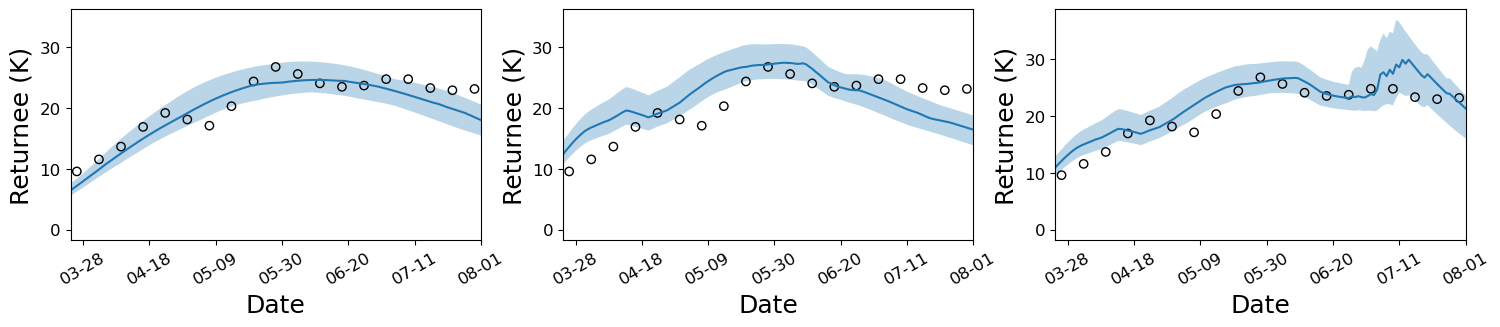

In [12]:
from matplotlib import rcParams

max_font_size = 20
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':14,'alpha':0.2}

fig,ax = plt.subplots(1,3,figsize=(18,3))    
plot_sim_and_gt(ax[0],final_sim_1,'Const',ukr_people_depart_poland_by_date,lgd_params,
                        top_k=1,gt_scale=1,not_plot_gt=0)
plot_sim_and_gt(ax[1],final_sim_2,'Conflict',ukr_people_depart_poland_by_date,lgd_params,
                       top_k=1,gt_scale=1,not_plot_gt=0)
plot_sim_and_gt(ax[2],final_sim_3,'Conflict-Peer',ukr_people_depart_poland_by_date,lgd_params,
                       top_k=1,gt_scale=1,not_plot_gt=0)

In [13]:
print(l1)
print(l2)
print(l3)

0.13094589008580593
0.293267154955568
0.16333945931836594


## Bayesian calibration of surrogate models

### Simplest one: Constant

In [14]:
%%time

opt = Optimizer([(0.0, 0.0005)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-const'

for i in range(0,100):
    #if(i%50==0):
    #    print(i)
    rr = opt.ask()
    ll,_ = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result after 50 iteration has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

ll_const,sim_df_const = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,opt.get_result()['x'],no_print=0)

with open(optimizer_name, 'wb') as f:
    pickle.dump(opt, f)

best result after 50 iteration has a loss of 0.12268729099030432 for [0.000186448348533052]
running surrogate model with hazard 0.000186448348533052
0.13110616739250508 0.9109882146184988
CPU times: user 2min 17s, sys: 120 ms, total: 2min 17s
Wall time: 23.2 s


## 8 category demographic

In [ ]:
%%time
## constant across single demographic
random_state = 42
opt = Optimizer([(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),
                 (0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009)], 
                "GP", acq_func="EI",acq_optimizer="sampling",random_state=random_state)

optimizer_name = f'return-optimizer-bayes-demo-surrrogate-const-{random_state}'

with open(f'optimizers/{optimizer_name}', 'rb') as f:
    opt = pickle.load(f)

for i in range(1000,1500):
    if(i%50==0):
        print(i,'saving optimizer...')
        with open(f'optimizers/{optimizer_name}', 'wb') as f:
            pickle.dump(opt, f)
    rr = opt.ask()
    ll,_,_,_,_ = estimate_blackbox_function_loss_per_demo(intention_sim_demo,surrogate_constant_haz,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)
    

print('best result after 1500 iteration has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

#ll_const,sim_df_const = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,opt.get_result()['x'],no_print=0)

with open(f'optimizers/{optimizer_name}', 'wb') as f:
    pickle.dump(opt, f)
    
#groups = ['single_male','single_female','male_only','female_only',
#              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']

1000 saving optimizer...
1050 saving optimizer...
1100 saving optimizer...


## 6 category demographic

In [13]:
%%time
## constant across single demographic
random_state = 42
opt = Optimizer([(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),
                 (0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009)], 
                "GP", acq_func="EI",acq_optimizer="sampling",random_state=random_state)

optimizer_name = f'return-optimizer-bayes-demo6-surrrogate-const-{random_state}'

with open(f'optimizers/{optimizer_name}', 'rb') as f:
    opt = pickle.load(f)

for i in range(1000,1200):
    if(i%50==0):
        print(i,'saving optimizer...')
        with open(f'optimizers/{optimizer_name}', 'wb') as f:
            pickle.dump(opt, f)
    rr = opt.ask()
    ll,_,_,_,_ = estimate_blackbox_function_loss_per_demo6(intention_sim_demo6,surrogate_constant_haz,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)
    

print('best result after 1000 iteration has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

#ll_const,sim_df_const = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,opt.get_result()['x'],no_print=0)

with open(f'optimizers/{optimizer_name}', 'wb') as f:
    pickle.dump(opt, f)
    
#groups = ['single_male','single_female','male_only','female_only',
#              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']

1000 saving optimizer...
1050 saving optimizer...
1100 saving optimizer...
1150 saving optimizer...
best result after 1000 iteration has a loss of 0.12089372144576456 for [0.0007312250250868886, 0.00021498873108461065, 0.00019015680239148564, 0.00016492361863663075, 0.0001708670540257478, 0.00020624708322805214]
CPU times: user 9h 54min 42s, sys: 25min 13s, total: 10h 19min 56s
Wall time: 2h 36min 25s


In [16]:
len(opt.get_result()['x_iters'])

400

In [ ]:
%%time
## constant across single demographic
random_state = 42
opt = Optimizer([(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),
                 (0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009)], 
                "GP", acq_func="EI",acq_optimizer="sampling",random_state=random_state)

optimizer_name = f'return-optimizer-bayes-demo-surrrogate-const-{random_state}'

with open(f'optimizers/{optimizer_name}', 'rb') as f:
    opt = pickle.load(f)

for i in range(0,600):
    if(i%50==0):
        print(i)
    rr = opt.ask()
    ll,_,_,_,_ = estimate_blackbox_function_loss_per_demo(intention_sim,surrogate_constant_haz,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result after 1000 iteration has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

#ll_const,sim_df_const = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,opt.get_result()['x'],no_print=0)

with open(f'optimizers/{optimizer_name}', 'wb') as f:
    pickle.dump(opt, f)

### Simplest one: Constant (loss is nrmse)

In [11]:
%%time

opt = Optimizer([(0.0, 0.0005)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

for i in range(0,50):
    #if(i%50==0):
    #    print(i)
    rr = opt.ask()
    ll,_ = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,rr,no_print=5)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result after 50 iteration has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

ll_const,sim_df_const = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,opt.get_result()['x'],no_print=0)

best result after 50 iteration has a loss of 0.1267860121021766 for [0.00018404281883310718]
running surrogate model with hazard 0.00018404281883310718
CPU times: user 7.92 s, sys: 54.7 ms, total: 7.98 s
Wall time: 8.23 s


## now: gradient-based optimization

In [13]:
from micrograd.engine import Value

def surrogate_constant_haz_D(intention_sim_df,h,not_print_flag=0): ##h here must be a value from micrograd.engine Value class
    if not not_print_flag:
        print('running surrogate model with hazard',h)
    M = [Value(x) for x in intention_sim_df['h_size'].tolist()]
    R = []
    for sim in range(0,len(M)):
        R.append(Value(0.0))
    for sim in range(0,len(M)):
        if not not_print_flag:
            print('sim:',sim)
        S = Value(1.0)
        #R.append(0)
        past_sim = sim
        while(past_sim>=0):
            #print('past sim:',past_sim)
            Returnee = M[past_sim]-M[past_sim]*S
            R[sim] = R[sim] + Returnee
            M[past_sim] = M[past_sim] - Returnee
            S = S*(Value(1.0)-h)
            past_sim = past_sim - 1
            
    return_df = intention_sim_df.copy(deep=True)
    return_df['returnee'] = pd.Series(R)
    return return_df.rename(columns={'move_date':'return_date'})

def get_mean_estimation(all_dfs):
    denom = Value(len(all_dfs))
    mean_df = pd.concat(all_dfs).groupby('return_date')['returnee'].sum().reset_index()
    mean_df['returnee'] = mean_df['returnee']/denom
    return mean_df

def compute_loss_D(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0,print_flag=1):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & 
                          (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/1.0
    rangeval = Value(merged_df[observe_col].max()-merged_df[observe_col].min())
    merged_df[observe_col] = merged_df[observe_col].apply(lambda x: Value(x))
    mse = (((merged_df['returnee']-merged_df[observe_col])**2).sum())/merged_df.shape[0]
    #corr = merged_df['returnee'].corr(merged_df[observe_col], method='pearson')
    rmse = mse**0.5
    nrmse = rmse/rangeval
    return nrmse


# #intention_sim_median = pd.concat(intention_sim).groupby('move_date')['h_size'].quantile(q=0.5).reset_index()
# h = Value(0.0002)
# lr = Value(5e-9)

# for iteration in range(0,10):
    
#     all_dfs = []
#     for sim_df in intention_sim:
#         ret_df = surrogate_constant_haz_D(sim_df,h,not_print_flag=1)
#         all_dfs.append(ret_df)
        
#     ret_df_mean = get_mean_estimation(all_dfs) 
#     nrmse = compute_loss_D(ret_df_mean,ukr_people_depart_poland_by_date,'departure','2022-04-01','2022-08-01')
#     print('at iteration',iteration,'loss is',nrmse.data,end=', ')
#     nrmse.backward()
#     grad = h.grad
#     print('gradient is',grad,end=', ')
#     h = h - lr*grad
#     print('new value of h is',h.data)

In [ ]:
%%time
#intention_sim_median = pd.concat(intention_sim).groupby('move_date')['h_size'].quantile(q=0.5).reset_index()
hs = [Value(0.0002) for i in range(len(intention_sim))]
lr = Value(5e-9)

for iteration in range(0,20):
    
    all_dfs = []
    for idx,sim_df in enumerate(intention_sim):
        ret_df = surrogate_constant_haz_D(sim_df,hs[idx],not_print_flag=1)
        all_dfs.append(ret_df)
    
    print('forward pass done')
    ret_df_mean = get_mean_estimation(all_dfs) 
    nrmse = compute_loss_D(ret_df_mean,ukr_people_depart_poland_by_date,'departure','2022-04-01','2022-08-01')
    print('at iteration',iteration,'loss is',nrmse.data,end=', ')
    nrmse.backward()
    grads = [h.grad for h in hs]
    avg_grad = sum(grads)/len(grads)
    print('avg gradient is',avg_grad,end=', ')
    hs = [h - lr*avg_grad for h in hs]
    print('new value of h is',hs[0].data)

forward pass done
at iteration 0 loss is 0.13803652302151498, avg gradient is 45.21310982373281, new value of h is 0.00019977393445088135
forward pass done
at iteration 1 loss is 0.13774168344039622, avg gradient is 44.73239795958626, new value of h is 0.00019955027246108342
forward pass done
at iteration 2 loss is 0.13745309567493946, avg gradient is 44.251993951457514, new value of h is 0.00019932901249132613
forward pass done
at iteration 3 loss is 0.13717068835218135, avg gradient is 43.77203473677708, new value of h is 0.00019911015231764223
forward pass done
at iteration 4 loss is 0.1368943885135323, avg gradient is 43.292655717232044, new value of h is 0.00019889368903905607
forward pass done
at iteration 5 loss is 0.13662412170974497, avg gradient is 42.81399061241798, new value of h is 0.00019867961908599398
forward pass done
at iteration 6 loss is 0.13635981209791337, avg gradient is 42.336171321592495, new value of h is 0.00019846793822938602
forward pass done
at iteration 7

### Next: Conflict with roll and lag

In [15]:
%%time
opt = Optimizer([(0.0, 0.0005),(21,22),(14,15)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-gc-21-14'

# opt = Optimizer([(0.0, 0.0005),(30,31),(7,8)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

# optimizer_name = 'return-optimizer-bayes-surrrogate-gc-21-14'

for i in range(0,100):
    #if(i%50==0):
    #    print(i)
    rr = opt.ask()
    #print(rr)
    ll,_ = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

# ll_conf,sim_df_conf = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz,opt.get_result()['x'],no_print=0)

with open(optimizer_name, 'wb') as f:
    pickle.dump(opt, f)

best result has a loss of 0.12690114979542455 for [0.0003629656949648399, np.int64(21), np.int64(15)]
CPU times: user 3min 50s, sys: 1.86 s, total: 3min 52s
Wall time: 1min 47s


In [17]:
%%time
opt = Optimizer([(0.0, 0.005),(0.0, 0.0005),(0.0,1.0),(21,22),(14,15)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-gc-peer-21-14'

opt = Optimizer([(0.0, 0.005),(0.0, 0.0005),(0.0,1.0),(30,31),(7,8)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-gc-peer-30-7'

opt = Optimizer([(0.0, 0.005),(0.0, 0.0005),(0.0,1.0),(35,36),(7,8)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-gc-peer-35-7'

for i in range(0,150):
    if(i%30==0):
        print(i)
    rr = opt.ask()
    #print(rr)
    ll,_,_,_,_ = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz_with_peer,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

with open('optimizers/'+optimizer_name, 'wb') as f:
    pickle.dump(opt, f)

#ll_conf_peer,sim_df_conf_peer = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz_with_peer,opt.get_result()['x'],no_print=0)

0
30
60
90
120
best result has a loss of 0.09519243999521187 for [0.0003331088027656926, 0.0002798499468995505, 0.473917145638435, np.int64(35), np.int64(7)]
CPU times: user 2min 55s, sys: 4.88 s, total: 3min
Wall time: 3min 9s


In [18]:
%%time
opt = Optimizer([(0.0, 0.005),(0.0, 0.0005),(0.0,1.0),(40,41),(7,8)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-gc-peer-40-7'

for i in range(0,150):
    if(i%30==0):
        print(i)
    rr = opt.ask()
    #print(rr)
    ll,_,_,_,_ = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz_with_peer,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

with open('optimizers/'+optimizer_name, 'wb') as f:
    pickle.dump(opt, f)

#ll_conf_peer,sim_df_conf_peer = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz_with_peer,opt.get_result()['x'],no_print=0)

0
30
60
90
120
best result has a loss of 0.11448429714583208 for [0.0002965034907438819, 0.0002454253591054051, 0.49433781090530926, np.int64(40), np.int64(7)]
CPU times: user 2min 52s, sys: 4.88 s, total: 2min 57s
Wall time: 3min 4s


In [19]:
%%time

opt = Optimizer([(0.0, 0.005),(0.0, 0.0005),(0.0,1.0),(45,46),(7,8)], "GP", acq_func="EI",acq_optimizer="sampling",random_state=42)

optimizer_name = 'return-optimizer-bayes-surrrogate-gc-peer-45-7'

for i in range(0,150):
    if(i%30==0):
        print(i)
    rr = opt.ask()
    #print(rr)
    ll,_,_,_,_ = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz_with_peer,rr,no_print=1)
    #print(next_h,ll)
    opt.tell(rr,ll)

print('best result has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#dicts.append({'roll':roll,'lag':lag,'best_x':opt.get_result()['x'][0],'loss':opt.get_result()['fun']})

with open('optimizers/'+optimizer_name, 'wb') as f:
    pickle.dump(opt, f)

#ll_conf_peer,sim_df_conf_peer = estimate_blackbox_function_loss(intention_sim,surrogate_conflict_haz_with_peer,opt.get_result()['x'],no_print=0)

0
30
60
90
120
best result has a loss of 0.15702753665119157 for [0.002386132057823872, 0.0002547229474306091, 0.6859916391649343, np.int64(45), np.int64(7)]
CPU times: user 2min 54s, sys: 4.9 s, total: 2min 59s
Wall time: 3min 6s


[88]
[40]
[115]
[64]
[53]
[85]


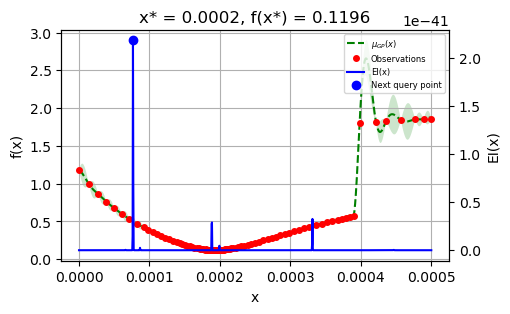

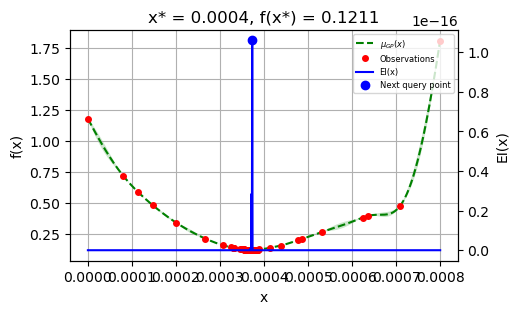

In [15]:
## Necessary imports

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from file_paths_and_consts import *
import os
import geopandas as gpd
import pandas as pd
import json
import sys
import argparse
import warnings
import pickle
import json
import pickle
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

from notebook_utils import *
warnings.filterwarnings('ignore')

TOPK = 1

labels = []
min_observe_idx = []
dir_name = []

ftypes = ['constant','constant_global_conflict_lagged_21_intensity',
          'constant_global_conflict_intensity_peer_lagged_21',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_30_peer',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_35_peer',
          'constant_global_conflict_intensity_kmax_rolling_7_lagged_40_peer']
modeltypes = ['ConstHaz','$GC_{21}^{14}$','$GC_{21}^{14}-Peer$','$GC_{30}^{7}-Peer$'
              ,'$GC_{35}^{7}-Peer$','$GC_{40}^{7}-Peer$']

opts = []


for idx,ftype in enumerate(ftypes):
    modeltype = modeltypes[idx]
    
    optimizer_name = f'optimizers/return-optimizer-Bayesian_opt3-{ftype}.pkl'
    dirs = f'RETURN_HAZARD_Bayesian_opt3_{ftype}'
    
    with open(optimizer_name, 'rb') as f:
        opt = pickle.load(f)
    
    xs = opt.get_result()['x_iters']
    ys = opt.get_result()['func_vals']

    labels.append(modeltype)
    min_observe = findminobservation_idx(xs,ys,k=TOPK)
    print(min_observe)
    opts.append(np.array(xs)[min_observe])
    min_observe_idx.append(min_observe)
    dir_name.append(dirs)

    if len(xs[0])==1:    
        plot_args = {"show_legend": True,"show_title": True, "show_next_point": True,"show_acq_func": True}
        fig, ax = plt.subplots(figsize=(5,3))
        plot_gaussian_process(opt.get_result(),ax=ax, **plot_args)


In [16]:
def plot_sim_and_gt_ABM(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,add_error=0,add_legend=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,not_plot_gt=0,coverage=0.5):
    #print('visualization for',model_name)
    base_color = '#08519c'
    cover_alpha_dict = {0.5:0.3,0.9:0.2,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3
    
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color,label=str(int(coverage*100))+'% CI')
    #ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    if add_legend==1:
        ax.plot(sim_df['return_date'],sim_df['Total']/1000,alpha=0.8/top_k,color=base_color,linewidth=3,label='ABM')
    else:
        ax.plot(sim_df['return_date'],sim_df['Total']/1000,alpha=0.8/top_k,color=base_color,linewidth=3)
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200)
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
        
    ll,corr,err = compute_loss_ABM(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)

    handles, labels = ax.get_legend_handles_labels()
    #print(labels)
    err_patch = mpatches.Patch(color='#ec7014', label='NRMSE: '+str(round(err,4)))
    corr_patch = mpatches.Patch(color='#41ab5d', label='PCC: '+str(round(corr,4)))
    
    if add_error:
        handles.extend([err_patch,corr_patch])
        #handles.append(corr_patch)
        handles, labels = ax.get_legend_handles_labels()
        #print('after error adding')
        #print(labels)
    
    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    #ax.set_title(model_name)
    ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)
    
def plot_sim_and_gt_SGT(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,not_plot_gt=0,coverage=0.5):
    #print('visualization for',model_name)
    base_color = '#d95f0e'
    cover_alpha_dict = {0.5:0.3,0.9:0.2,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3
    
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color,label=str(int(coverage*100))+'% CI')
    #ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    if add_legend==1:
        ax.plot(sim_df['return_date'],sim_df['returnee']/1000,alpha=0.8/top_k,color=base_color,linewidth=3,label='Surrogate')
    else:
        ax.plot(sim_df['return_date'],sim_df['returnee']/1000,alpha=0.8/top_k,color=base_color,linewidth=3)
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200)
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
            
    #ll,err,corr = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)
    
    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    #ax.set_title(f'NRMSE: {round(err,4)}\nPCC: {round(corr,4)}')
    ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)


COUNTRY: POLAND, MODEL: {} ConstHaz
crps 0.06650725234040986
nrmse 0.13110616739250508 corr 0.9109882146184988 loss 0.12268729099030432
loss again 0.12268729099030432
nrmse 0.13110616739250508 corr 0.9109882146184988 loss 0.12268729099030432
loss again 0.12268729099030432

COUNTRY: POLAND, MODEL: {} $GC_{21}^{14}$
crps 0.059269806731064294
nrmse 0.13454057912012737 corr 0.9036565675033867 loss 0.12690114979542455
loss again 0.12690114979542455
nrmse 0.13454057912012737 corr 0.9036565675033867 loss 0.12690114979542455
loss again 0.12690114979542455

COUNTRY: POLAND, MODEL: {} $GC_{21}^{14}-Peer$
crps 0.056661620973003576
nrmse 0.12613340992630304 corr 0.9078067722962999 loss 0.11934537348178245
loss again 0.11934537348178245
nrmse 0.12613340992630304 corr 0.9078067722962999 loss 0.11934537348178245
loss again 0.11934537348178245

COUNTRY: POLAND, MODEL: {} $GC_{30}^{7}-Peer$
crps 0.05093883708209886
nrmse 0.11494399923812139 corr 0.9174644214030356 loss 0.10846231510988999
loss again 0

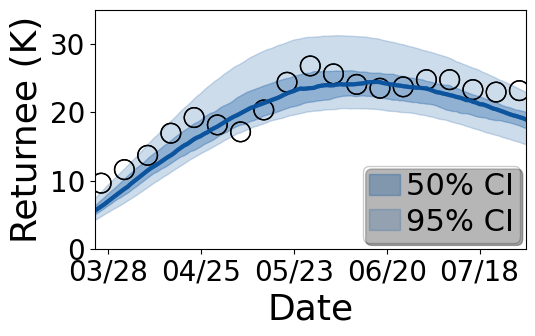

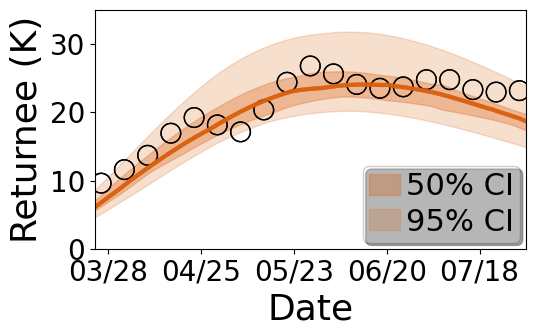

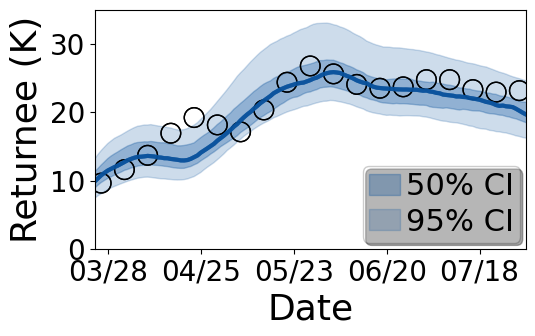

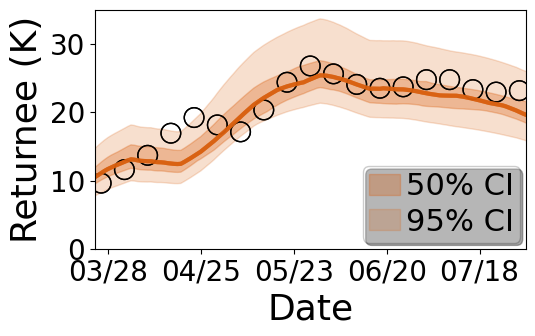

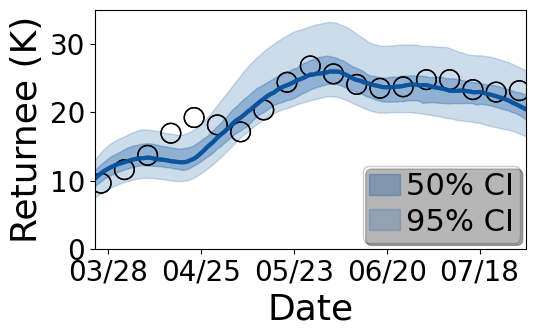

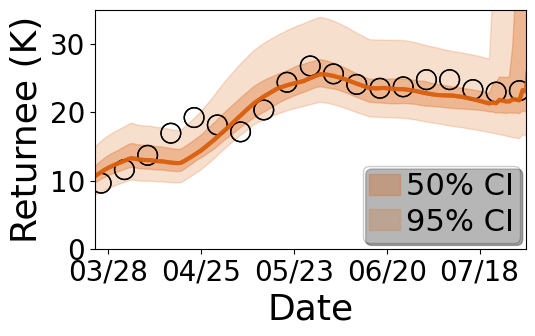

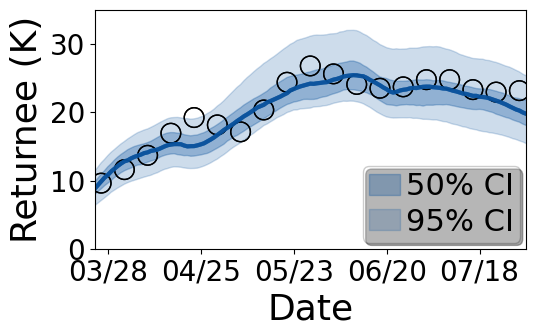

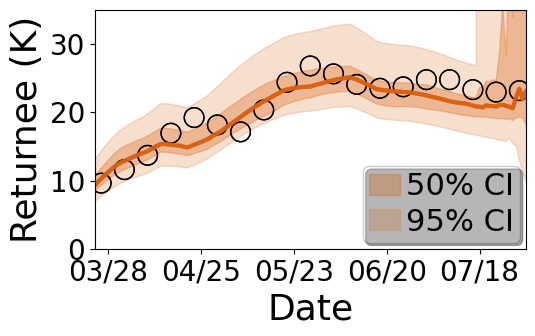

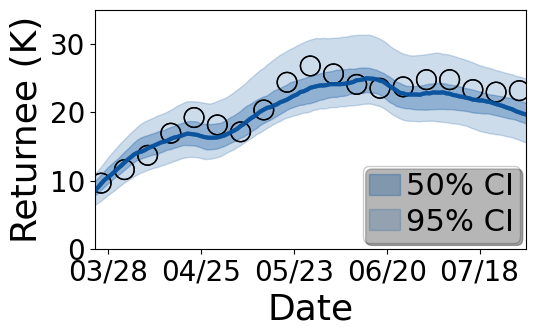

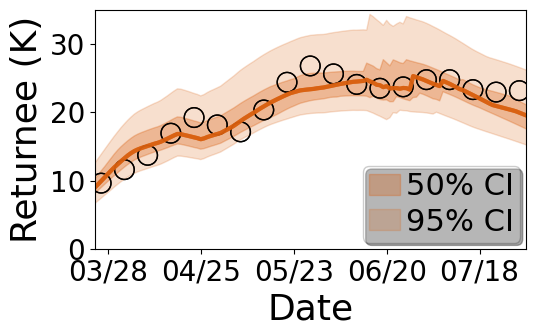

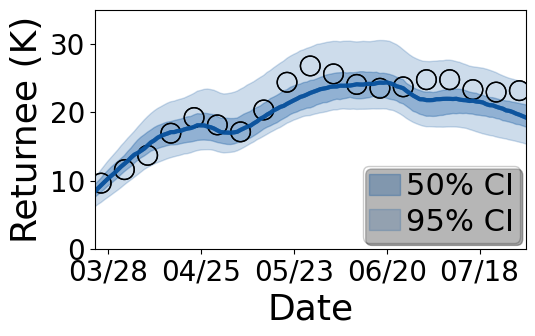

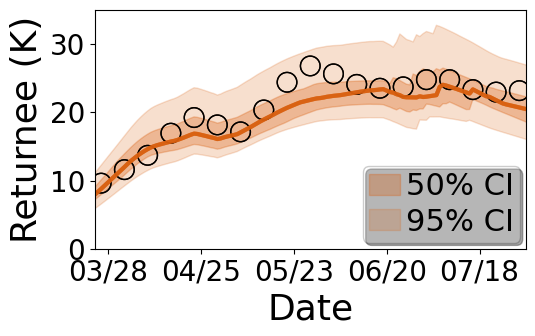

In [19]:
from matplotlib import rcParams

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

covers = []

result_dict = []

sim_df_abms = []
sim_df_surrogates = []

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer']

surrogate_ftypes = ['const','gc-21-14','gc-peer-21-14','gc-peer-30-7','gc-peer-35-7','gc-peer-40-7']
#modeltypes = ['ConstHaz','$GC_{21}^{14}$','$GC_{21}^{14}-Peer$','$GC_{30}^{7}-Peer$'
#              ,'$GC_{35}^{7}-Peer$','$GC_{40}^{7}-Peer$','$GC_{45}^{7}-Peer$']

surrogate_possible_funcs = [surrogate_constant_haz,surrogate_conflict_haz]+5*[surrogate_conflict_haz_with_peer]

for iddd in range(len(dir_name)):
    fig,ax = plt.subplots(figsize=(6,4))
    off = 1
    
    print('\nCOUNTRY: POLAND, MODEL: {}',modeltypes[iddd])
    for modelk in range(TOPK):
        all_sim_df = get_all_estimation(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0)
        crps = get_crps(all_sim_df,ukr_people_depart_poland_by_date,'departure','2022-03-24','2022-08-01')
        print('crps',crps)
        sim_df_1 = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,alpha=0.5)
        sim_df_abms.append(sim_df_1)
        sim_df_2 = get_estimation_Q1_Q3(str(min_observe_idx[iddd][modelk]+off).zfill(9),dir_name[iddd],all_raions,'PL',cache_clean_mode=0,alpha=0.9)
        plot_sim_and_gt_ABM(ax,sim_df_1,modeltypes[iddd],ukr_people_depart_poland_by_date,lgd_params,add_legend=0,
                        top_k=TOPK,gt_scale=scale_purifier(1),not_plot_gt=modelk,add_error=1,date_start='2022-03-24',date_end='2022-08-01')
        plot_sim_and_gt_ABM(ax,sim_df_2,modeltypes[iddd],ukr_people_depart_poland_by_date,lgd_params,
                        top_k=TOPK,gt_scale=scale_purifier(1),not_plot_gt=modelk,coverage=0.95,date_start='2022-03-24',date_end='2022-08-01')
        #corr,err = plot_error(ax,sim_df_1,'',ukr_people_depart_poland_by_date,lgd_params,date_start='2022-03-24',date_end='2022-08-01')
        ax.set_ylim([0,35])
    
    fig.tight_layout()
    fig.savefig('Figures/'+fig_model_names[iddd]+'_return_estimation_ABM.png', bbox_inches='tight',dpi=350)
    
    fig,ax = plt.subplots(figsize=(6,4))
    optimizer_name = f'optimizers/return-optimizer-bayes-surrrogate-{surrogate_ftypes[iddd]}'
    
    with open(optimizer_name, 'rb') as f:
        opt = pickle.load(f)
    
    _,nrsme,corr,crps,sim_df_1 = estimate_blackbox_function_loss(intention_sim,surrogate_possible_funcs[iddd],
                                                                 opt.get_result()['x'],no_print=1,date_start='2022-04-01',date_end='2022-08-01',q1=0.25,q3=0.75)
    _,nrsme,corr,crps,sim_df_2 = estimate_blackbox_function_loss(intention_sim,surrogate_possible_funcs[iddd],
                                                                      opt.get_result()['x'],no_print=1,date_start='2022-04-01',date_end='2022-08-01',q1=0.025,q3=0.975)
    sim_df_surrogates.append(sim_df_1)
    #print(nrmse,corr)
    plot_sim_and_gt_SGT(ax,sim_df_1,modeltype,ukr_people_depart_poland_by_date,lgd_params,add_legend=0,top_k=1,gt_scale=1,not_plot_gt=0,date_start='2022-03-24',date_end='2022-08-01',coverage=0.5)
    plot_sim_and_gt_SGT(ax,sim_df_2,modeltype,ukr_people_depart_poland_by_date,lgd_params,top_k=1,gt_scale=1,not_plot_gt=0,date_start='2022-03-24',date_end='2022-08-01',coverage=0.95)
    ax.set_ylim([0,35])
    fig.tight_layout()
    #fig.savefig('Figures/'+fig_model_names[iddd]+'_return_estimation_S.png', bbox_inches='tight',dpi=350)


In [20]:
sim_df_abms[0]

,return_date,Total,q1,q3
0,2022-03-02,39.000000,30.571429,45.428571
1,2022-03-03,81.285714,63.142857,102.678571
2,2022-03-04,166.857143,140.571429,250.428571
3,2022-03-05,314.285714,249.000000,421.000000
4,2022-03-06,472.000000,405.285714,615.142857
...,...,...,...,...
179,2022-08-28,14653.857143,12506.857143,15530.857143
180,2022-08-29,14504.142857,12302.142857,15298.000000
181,2022-08-30,14374.428571,12088.285714,15152.000000
182,2022-08-31,14237.142857,11947.428571,14999.428571


In [25]:
def compute_loss_ABM(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',sim_col='Total',gt_scale=1.0):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    mse = (((merged_df[sim_col]-merged_df[observe_col])**2).sum())/merged_df.shape[0]
    corr = merged_df[sim_col].corr(merged_df[observe_col], method='pearson')
    rmse = mse**0.5
    nrmse = rmse/(max(merged_df[observe_col])-min(merged_df[observe_col]))
    return nrmse,corr

for sim_df in sim_df_abms:
    nrmse_med,corr_med = compute_loss_ABM(sim_df,ukr_people_depart_poland_by_date, 'departure','2022-03-24','2022-08-01',gt_scale=1,sim_col='Total')
    nrmse_q1,corr_q1 = compute_loss_ABM(sim_df,ukr_people_depart_poland_by_date, 'departure','2022-03-24','2022-08-01',gt_scale=1,sim_col='q1')
    nrmse_q3,corr_q3 = compute_loss_ABM(sim_df,ukr_people_depart_poland_by_date, 'departure','2022-03-24','2022-08-01',gt_scale=1,sim_col='q3')
    
    print(round(nrmse_med,4),round(nrmse_med-nrmse_q1,4),round(nrmse_q3-nrmse_med,4))
    print(round(corr_med,4),round(corr_med-corr_q1,4),round(corr_q3-corr_med,4))
    print('')
    
for sim_df in sim_df_surrogates:
    nrmse_med,corr_med = compute_loss_ABM(sim_df,ukr_people_depart_poland_by_date, 'departure','2022-04-01','2022-08-01',gt_scale=1,sim_col='returnee')
    nrmse_q1,corr_q1 = compute_loss_ABM(sim_df,ukr_people_depart_poland_by_date, 'departure','2022-04-01','2022-08-01',gt_scale=1,sim_col='q1')
    nrmse_q3,corr_q3 = compute_loss_ABM(sim_df,ukr_people_depart_poland_by_date, 'departure','2022-04-01','2022-08-01',gt_scale=1,sim_col='q3')
    
    print(round(nrmse_med,4),round(nrmse_med-nrmse_q1,4),round(nrmse_q3-nrmse_med,4))
    print(round(corr_med,4),round(corr_med-corr_q1,4),round(corr_q3-corr_med,4))
    print('')

0.1203 -0.071 -0.0044
0.947 -0.0008 -0.0182

0.1125 -0.0584 0.0089
0.9264 -0.0083 -0.0055

0.1063 -0.052 0.0207
0.9294 -0.002 -0.0001

0.0887 -0.0736 0.0132
0.9515 -0.001 -0.0014

0.0936 -0.0789 0.003
0.9576 0.0014 -0.0029

0.1071 -0.0813 -0.005
0.9502 0.0028 -0.0054

0.1311 -0.0786 0.0005
0.911 -0.0093 -0.03

0.1345 -0.0662 -0.0
0.9037 -0.0134 -0.0145

0.1261 -0.066 0.1183
0.9078 -0.0108 -0.1477

0.1149 -0.0804 0.5688
0.9175 -0.0075 -0.5442

0.1016 -0.0704 0.0541
0.9303 -0.0024 -0.0243

0.1281 -0.0922 -0.0219
0.9399 0.0033 0.0018



In [18]:
def plot_sim_and_gt(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,not_plot_gt=0,coverage=0.5):
    #print('visualization for',model_name)
    base_color = '#d95f0e'
    cover_alpha_dict = {0.5:0.3,0.9:0.2,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3
    
    #ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color,label=str(int(coverage*100))+'% CI')
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    if add_legend==1:
        ax.plot(sim_df['return_date'],sim_df['returnee']/1000,alpha=0.8/top_k,color=base_color,linewidth=3,label='Surrogate')
    else:
        ax.plot(sim_df['return_date'],sim_df['returnee']/1000,alpha=0.8/top_k,color=base_color,linewidth=3)
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200)
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
            
    #ll,err,corr = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)
    
    myFmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="lower right", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=True, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    #ax.set_title(f'NRMSE: {round(err,4)}\nPCC: {round(corr,4)}')
    ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)

nrmse 0.11878518716196296 corr 0.9407730067818967 loss 0.10687354837319103
loss again 0.10687354837319103
nrmse 0.11878518716196296 corr 0.9407730067818967 loss 0.10687354837319103
loss again 0.10687354837319103
0
0.13110616739250508 0.9109882146184988
corr: 0.9109882146184988
nrmse: 0.13110616739250508
nrmse 0.11816780749913089 corr 0.9195373913729704 loss 0.11062676772471063
loss again 0.11062676772471063
nrmse 0.11816780749913089 corr 0.9195373913729704 loss 0.11062676772471063
loss again 0.11062676772471063
0
0.13454057912012737 0.9036565675033867
corr: 0.9036565675033867
nrmse: 0.13454057912012737
nrmse 0.1114898369611478 corr 0.9230803028848127 loss 0.1045758089919557
loss again 0.1045758089919557
nrmse 0.1114898369611478 corr 0.9230803028848127 loss 0.1045758089919557
loss again 0.1045758089919557
0
0.12613340992630304 0.9078067722962999
corr: 0.9078067722962999
nrmse: 0.12613340992630304
nrmse 0.10039103033514919 corr 0.9426917282565436 loss 0.09177447861681065
loss again 0.091

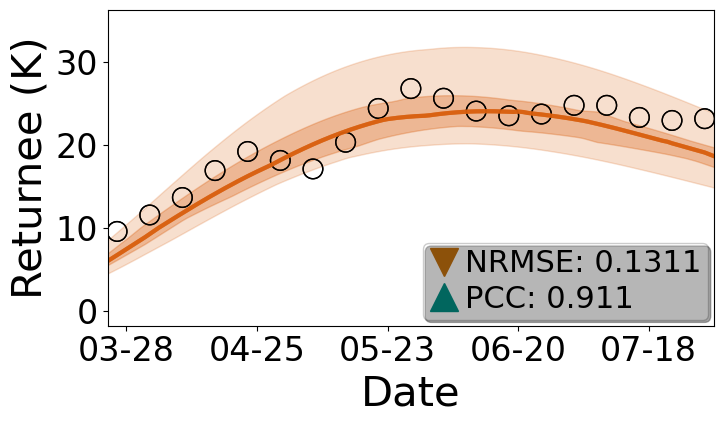

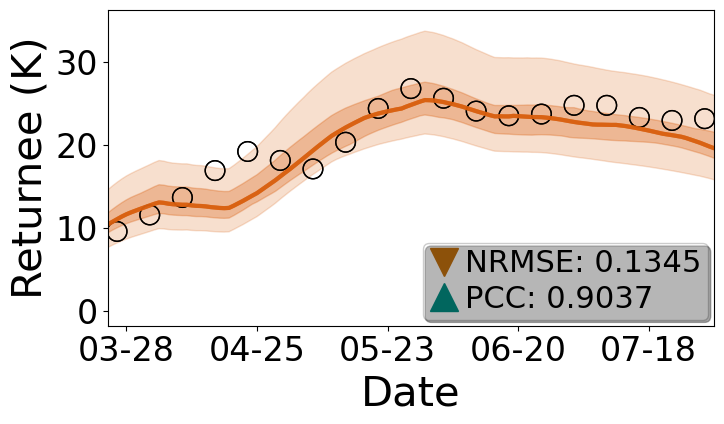

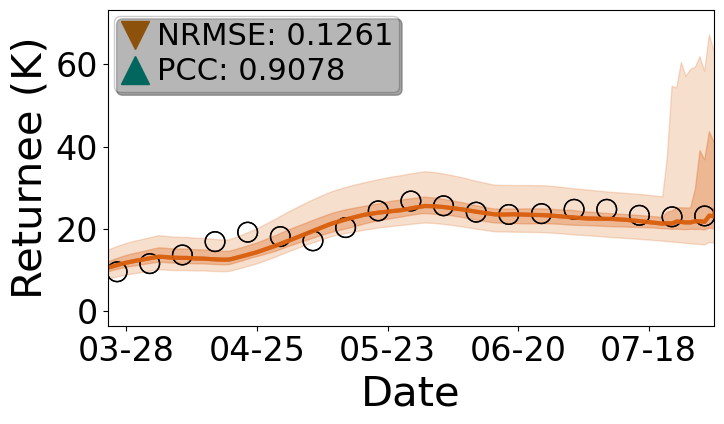

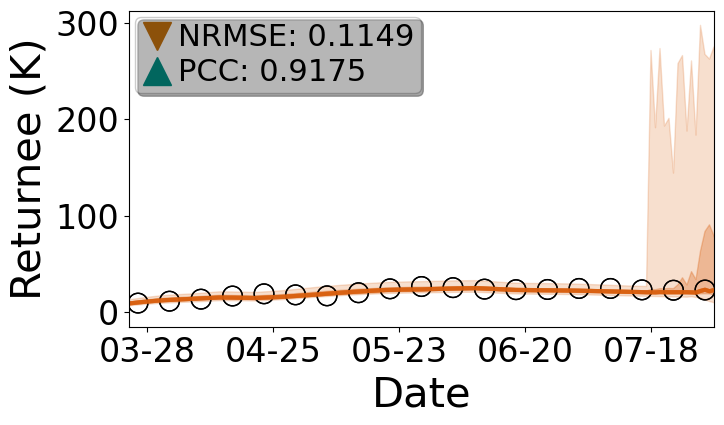

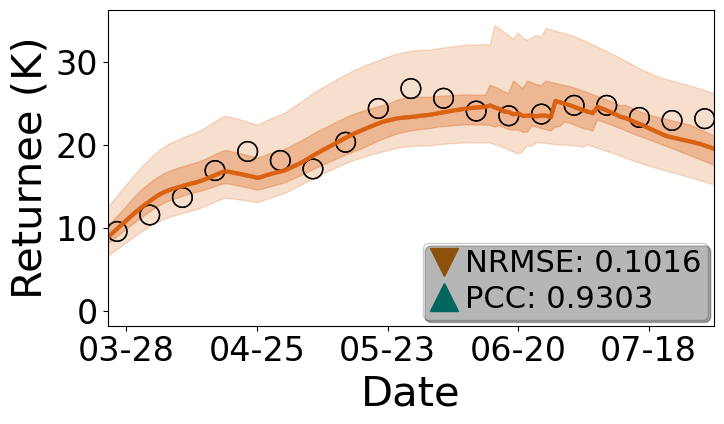

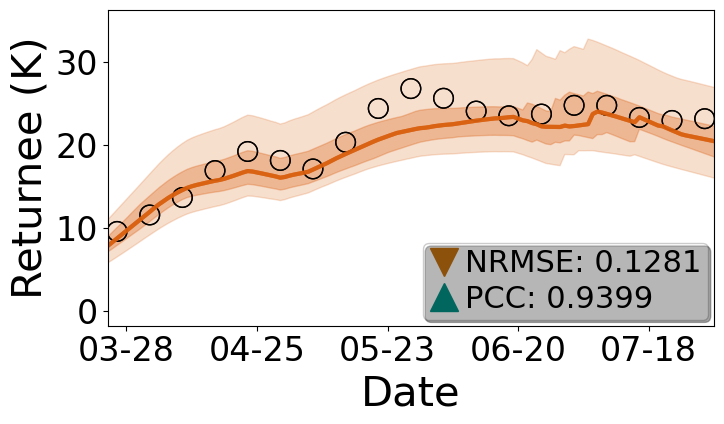

In [19]:
from matplotlib import rcParams

max_font_size = 32
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
# lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':16,'alpha':0.2}
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

ftypes = ['const','gc-21-14','gc-peer-21-14','gc-peer-30-7','gc-peer-35-7','gc-peer-40-7']
modeltypes = ['ConstHaz','$GC_{21}^{14}$','$GC_{21}^{14}-Peer$','$GC_{30}^{7}-Peer$'
              ,'$GC_{35}^{7}-Peer$','$GC_{40}^{7}-Peer$','$GC_{45}^{7}-Peer$']

possible_funcs = [surrogate_constant_haz,surrogate_conflict_haz]+5*[surrogate_conflict_haz_with_peer]

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer','gc_45_peer']

result_dicts = []

for idx,ftype in enumerate(ftypes):
    
    fig,ax = plt.subplots(figsize=(8,5))
    
    modeltype = '$S$-'+modeltypes[idx]
    
    optimizer_name = f'optimizers/return-optimizer-bayes-surrrogate-{ftype}'
    
    with open(optimizer_name, 'rb') as f:
        opt = pickle.load(f)
    
    _,nrsme,corr,crps,sim_df_1 = estimate_blackbox_function_loss(intention_sim,possible_funcs[idx],opt.get_result()['x'],no_print=1,date_start='2022-03-24',date_end='2022-08-01',q1=0.25,q3=0.75)
    _,nrsme,corr,crps,sim_df_2 = estimate_blackbox_function_loss(intention_sim,possible_funcs[idx],opt.get_result()['x'],no_print=1,date_start='2022-03-24',date_end='2022-08-01',q1=0.025,q3=0.975)
    #ll,nrmse,corr = compute_loss(sim_df, ukr_people_depart_poland_by_date, 'departure', '2022-03-01', '2022-08-01',print_flag=0)
    result_dicts.append({'model':modeltype,'crps':crps,'nrmse':nrsme,'corr':corr})
    print(crps)
    plot_sim_and_gt(ax,sim_df_1,modeltype,ukr_people_depart_poland_by_date,lgd_params,top_k=1,gt_scale=1,not_plot_gt=0,date_start='2022-03-24',date_end='2022-08-01',coverage=0.5)
    plot_sim_and_gt(ax,sim_df_2,modeltype,ukr_people_depart_poland_by_date,lgd_params,top_k=1,gt_scale=1,not_plot_gt=0,date_start='2022-03-24',date_end='2022-08-01',coverage=0.95)
    _,_ = plot_error(ax,sim_df_1,'',ukr_people_depart_poland_by_date,lgd_params)
    #ax.set_ylim([0,35])
    fig.tight_layout()
    #fig.savefig('Figures/S-'+fig_model_names[idx]+'_return_estimation.png', bbox_inches='tight',dpi=350)

In [20]:
pd.DataFrame.from_dict(result_dicts)

,model,crps,nrmse,corr
0,$S$-ConstHaz,0,0.118785,0.940773
1,$S$-$GC_{21}^{14}$,0,0.118168,0.919537
2,$S$-$GC_{21}^{14}-Peer$,0,0.111490,0.923080
3,$S$-$GC_{30}^{7}-Peer$,0,0.100391,0.942692
4,$S$-$GC_{35}^{7}-Peer$,0,0.088733,0.952652
5,$S$-$GC_{40}^{7}-Peer$,0,0.110885,0.958867


## for case study

0.12921474534436514 0.9123903741486378
corr: 0.9123903741486378
nrmse: 0.12921474534436514


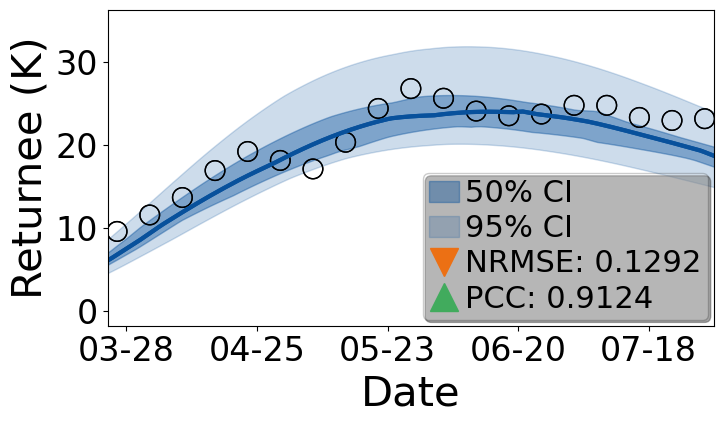

In [20]:
from matplotlib import rcParams

max_font_size = 32
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
# lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':16,'alpha':0.2}
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

    
fig,ax = plt.subplots(figsize=(8,5))
    
modeltype = 'Demo-Const'
    
optimizer_name = f'optimizers/return-optimizer-bayes-demo6-surrrogate-const-42'
    
with open(optimizer_name, 'rb') as f:
    opt = pickle.load(f)
    
_,nrsme,corr,crps,sim_df_1 = estimate_blackbox_function_loss_per_demo6(intention_sim_demo6,surrogate_constant_haz,
                                                                      opt.get_result()['x'],no_print=1,
                                                                      date_start='2022-04-01',date_end='2022-08-01',
                                                                      q1=0.25,q3=0.75)
_,nrsme,corr,crps,sim_df_2 = estimate_blackbox_function_loss_per_demo6(intention_sim_demo6,surrogate_constant_haz,
                                                                      opt.get_result()['x'],no_print=1,
                                                                      date_start='2022-04-01',date_end='2022-08-01',
                                                                      q1=0.025,q3=0.975)
#result_dicts.append({'model':modeltype,'crps':crps,'nrmse':nrsme,'corr':corr})
#print(crps)
plot_sim_and_gt(ax,sim_df_1,modeltype,ukr_people_depart_poland_by_date,lgd_params,top_k=1,gt_scale=1,not_plot_gt=0,date_start='2022-03-24',date_end='2022-08-01',coverage=0.5)
plot_sim_and_gt(ax,sim_df_2,modeltype,ukr_people_depart_poland_by_date,lgd_params,top_k=1,gt_scale=1,not_plot_gt=0,date_start='2022-03-24',date_end='2022-08-01',coverage=0.95)
_,_ = plot_error(ax,sim_df_1,'',ukr_people_depart_poland_by_date,lgd_params)

fig.tight_layout()


In [15]:
alphas = [0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]

from matplotlib import rcParams

max_font_size = 32
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
# lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':16,'alpha':0.2}
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

ftypes = ['const','gc-21-14','gc-peer-21-14','gc-peer-30-7','gc-peer-35-7','gc-peer-40-7']
modeltypes = ['ConstHaz','$GC_{21}^{14}$','$GC_{21}^{14}-Peer$','$GC_{30}^{7}-Peer$'
              ,'$GC_{35}^{7}-Peer$','$GC_{40}^{7}-Peer$','$GC_{45}^{7}-Peer$']

possible_funcs = [surrogate_constant_haz,surrogate_conflict_haz]+5*[surrogate_conflict_haz_with_peer]

fig_model_names = ['const','gc_21','gc_21_peer','gc_30_peer','gc_35_peer','gc_40_peer','gc_45_peer']

result_dicts = []

covers = []

for idx,ftype in enumerate(ftypes):
    
    #fig,ax = plt.subplots(figsize=(8,5))
    
    modeltype = '$S$-'+modeltypes[idx]
    print(modeltype)
    optimizer_name = f'optimizers/return-optimizer-bayes-surrrogate-{ftype}'
    
    with open(optimizer_name, 'rb') as f:
        opt = pickle.load(f)
    
    cur_cover = []
    for alpha in alphas:
        _,nrsme,corr,crps,sim_df = estimate_blackbox_function_loss(intention_sim,possible_funcs[idx],opt.get_result()['x'],no_print=1,date_start='2022-04-01',date_end='2022-08-01',q1=0.5-alpha/2.0,q3=0.5+alpha/2.0)
        cover = get_CI_coverage(sim_df,ukr_people_depart_poland_by_date,'departure','2022-03-24','2022-08-01')
        cur_cover.append(cover)
    covers.append(cur_cover)

$S$-ConstHaz
$S$-$GC_{21}^{14}$
$S$-$GC_{21}^{14}-Peer$
$S$-$GC_{30}^{7}-Peer$
$S$-$GC_{35}^{7}-Peer$
$S$-$GC_{40}^{7}-Peer$


In [17]:
df = pd.DataFrame(zip(*covers),columns=fig_model_names[0:6])

In [19]:
df.to_csv('s-ci-coverage.csv',index=False)

## linreg with conflict data

21
(131, 21)
(131,)
nrmse 0.22265648965087761
corr 0.5693164618181357
30
(131, 30)
(131,)
nrmse 0.21315356831765533
corr 0.6169138848284682
35
(131, 35)
(131,)
nrmse 0.210659476959807
corr 0.6284850284115647
40
(131, 40)
(131,)
nrmse 0.20658201529749445
corr 0.6466741225847861


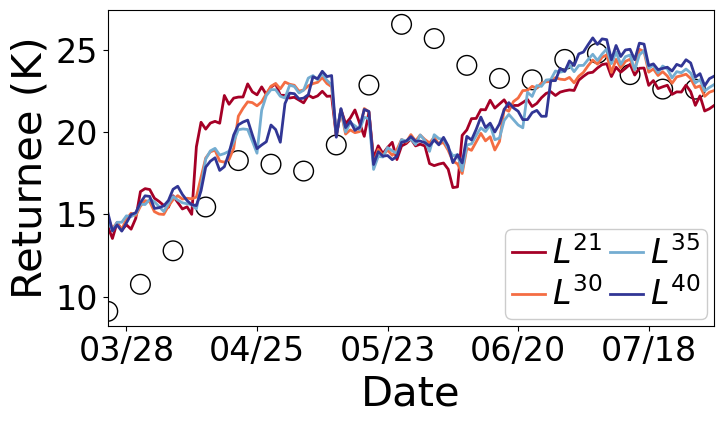

In [24]:
from sklearn.linear_model import LinearRegression

fig,ax = plt.subplots(figsize=(8,5))

def nrmse(predictions, targets):
    return (np.sqrt(((predictions - targets) ** 2).mean()))/(targets.max()-targets.min())

lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
              'ecolor':'black','size':24,'alpha':0.2}

linreg_colors = ['#a50026','#f46d43','#74add1','#313695']

for idx,feat_MAX in enumerate([21,30,35,40]):
    print(feat_MAX)    
    conflict_df = get_conflict_data(14,1)
    conflict_df = conflict_df.rename(columns={'conflict':'x_1'})
    feats = ['x_1']
    for lags in range(2,feat_MAX+1):
        cc = get_conflict_data(7,lags)
        cc = cc.rename(columns={'conflict':'x_'+str(lags)})
        feats.append('x_'+str(lags))
        conflict_df = conflict_df.merge(cc,on='move_date',how='inner')

    linreg_df = ukr_people_depart_poland_by_date.merge(conflict_df,left_on='return_date',right_on='move_date',how='inner')
    linreg_df = linreg_df[linreg_df.return_date>=pd.to_datetime('2022-03-24')]
    linreg_df = linreg_df[linreg_df.return_date<=pd.to_datetime('2022-08-01')]
    X = linreg_df[feats].values
    Y = linreg_df['departure'].values

    print(X.shape)
    print(Y.shape)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(X, Y)

    # Make predictions
    y_pred = model.predict(X)
    linreg_df['predicted'] = y_pred

    # Print the coefficients
    #print("Coefficients:", model.coef_)
    #print("Intercept:", model.intercept_)
    print('nrmse',nrmse(linreg_df['predicted'],linreg_df['departure']))
    print('corr',linreg_df['predicted'].corr(linreg_df['departure']))
    ax.plot(linreg_df['move_date'], linreg_df['predicted']/1000,label='$L^{'+str(feat_MAX)+'}$',color=linreg_colors[idx],linewidth=2)

ax.scatter(linreg_df['move_date'][::7], linreg_df['departure'][::7]/1000, facecolor='none',edgecolor='black',s=200)
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim([pd.to_datetime('2022-03-24'),pd.to_datetime('2022-08-01')])
ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})
ax.set_ylabel('Returnee (K)')
#ax.set_title(model_name)
ax.set_xlabel('Date')

fig.tight_layout()

fig.savefig('Figures/linreg-results.png',dpi=350,bbox_inches='tight')

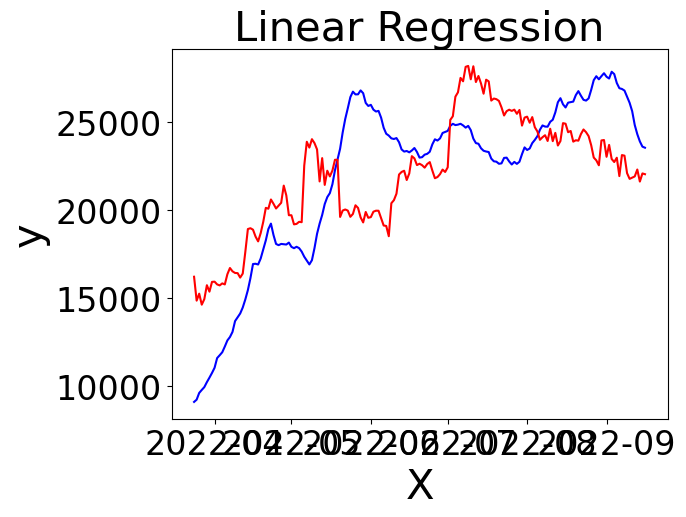

In [48]:
# Plot the data and the regression line
plt.plot(linreg_df['move_date'], linreg_df['departure'], color='blue')
plt.plot(linreg_df['move_date'], linreg_df['predicted'], color='red')
#plt.plot(X, y_pred, color='red')
plt.title('Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [27]:
pd.DataFrame.from_dict(result_dicts).to_csv('surrogate_results.csv',index=False)

## differentiation with micrograd

In [30]:
(pd.concat(pivoted_df)).pivot(index='move_date',columns='sim',values='returnee').reset_index()

sim,move_date,0,1,10,11,12,13,14,15,16,...,26,27,28,3,4,5,6,7,8,9
0,2022-02-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-02-25,3.248736,4.322139,5.597537,7.584121,8.530417,7.324304,8.270599,5.006580,5.296709,...,3.512629,6.562937,7.342389,8.427763,10.553172,4.902653,6.033877,8.818254,3.449458,5.961026
2,2022-02-26,31.594880,35.107963,42.267505,48.052274,49.524614,47.812269,55.447121,34.454076,34.804353,...,24.694998,42.168190,50.129979,54.070223,63.795704,32.715926,39.961675,68.148972,24.541958,38.812420
3,2022-02-27,86.954960,89.118838,104.673972,115.261463,111.319856,114.249010,134.167433,85.093924,84.229957,...,60.383311,101.043790,120.455319,129.853493,146.159093,77.921394,94.094640,175.726402,59.728122,92.661539
4,2022-02-28,169.230141,164.473135,191.814568,210.537641,194.156022,206.307664,243.433011,159.312407,154.683042,...,112.244725,183.776990,218.236931,236.856519,258.260287,140.441990,167.912803,329.746193,108.991774,167.862075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2022-08-30,8964.819889,20978.458794,5988.237752,4086.178775,8209.774112,15400.247883,4334.330022,7177.327925,5630.388507,...,9357.731916,8662.218433,10406.562921,4972.353731,13360.788569,37970.612427,121190.065757,6846.677384,17237.211680,10103.945870
188,2022-08-31,8469.024962,19080.487936,5693.230091,3950.133671,7810.230421,14162.010477,4166.611990,6867.271001,5410.152154,...,8808.256516,8196.077775,9716.861760,4806.813602,12371.291101,33515.959168,103221.519217,6569.472911,15807.531446,9498.362476
189,2022-09-01,8025.183119,17439.577456,5428.882216,3827.123224,7454.572274,13088.183448,4015.182820,6588.816726,5212.438596,...,8322.538872,7784.238125,9111.952880,4657.218618,11504.268477,29756.098065,88396.096571,6318.026439,14561.383998,8965.555587
190,2022-09-09,7660.850511,16068.029002,5213.602606,3731.898708,7171.148122,12196.226494,3894.376319,6368.009892,5058.611426,...,7928.885111,7451.938002,8611.833020,4542.055235,10782.667903,26639.538519,76259.314368,6116.050876,13519.107334,8532.763080


In [24]:
from micrograd.engine import Value

def surrogate_constant_haz_D(intention_sim_df,h,not_print_flag=0): ##h here must be a value from micrograd.engine Value class
    if not not_print_flag:
        print('running surrogate model with hazard',h)
    M = [Value(x) for x in intention_sim_df['h_size'].tolist()]
    R = []
    for sim in range(0,len(M)):
        R.append(Value(0.0))
    for sim in range(0,len(M)):
        if not not_print_flag:
            print('sim:',sim)
        S = Value(1.0)
        #R.append(0)
        past_sim = sim
        while(past_sim>=0):
            #print('past sim:',past_sim)
            Returnee = M[past_sim]-M[past_sim]*S
            R[sim] = R[sim] + Returnee
            M[past_sim] = M[past_sim] - Returnee
            S = S*(Value(1.0)-h)
            past_sim = past_sim - 1
            
    return_df = intention_sim_df.copy(deep=True)
    return_df['returnee'] = pd.Series(R)
    return return_df.rename(columns={'move_date':'return_date'})

def get_mean_estimation(all_dfs,Q1=0.2,Q3=0.8,cache_clean_mode=0):
    return_ensemble_df = pd.concat(all_dfs)
    median_df = return_ensemble_df.groupby('move_date')['returnee'].quantile(q=0.5).reset_index()
    q1_df = (return_ensemble_df.groupby('move_date')['returnee'].quantile(q=Q1).reset_index()).rename(columns={'returnee':'q1'})
    q3_df = (return_ensemble_df.groupby('move_date')['returnee'].quantile(q=Q3).reset_index()).rename(columns={'returnee':'q3'})
    return_uncertain_df = (median_df.merge(q1_df,on='move_date',how='inner')).merge(q3_df,on='move_date',how='inner')
    return_uncertain_df = return_uncertain_df.rename(columns={'move_date':'return_date'})
    return return_uncertain_df

def compute_loss_D(sim_df, observed_df, observe_col, date_start, date_end, date_col='return_date',gt_scale=1.0,print_flag=1):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & 
                          (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/1.0
    rangeval = Value(merged_df[observe_col].max()-merged_df[observe_col].min())
    merged_df[observe_col] = merged_df[observe_col].apply(lambda x: Value(x))
    nrmse = (sum((merged_df[observe_col]-merged_df['returnee'])**2)**0.5)/rangeval
    return nrmse


intention_sim_median = pd.concat(intention_sim).groupby('move_date')['h_size'].quantile(q=0.5).reset_index()
h = Value(0.0002)
lr = Value(1e-9)

for iteration in range(0,10):
    ret_df_median = surrogate_constant_haz_D(intention_sim_median,h,not_print_flag=1)
    nrmse = compute_loss_D(ret_df_median,ukr_people_depart_poland_by_date,'departure','2022-04-01','2022-08-01')
    print('at iteration',iteration,'loss is',nrmse,end=', ')
    nrmse.backward()
    grad = h.grad
    print('gradient is',grad,end=', ')
    h = h - lr*grad
    print('new value of h is',h)

at iteration 0 loss is Value(data=1.6922692081035546, grad=0), 

KeyboardInterrupt: 

## effect of loss on different surrogate models

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os 

def read_last_N_lines(filename,N):
    with open(filename, "r") as f:
        lines = f.readlines()
        if len(lines)<N:
            f.close()
            return ''
        last_lines = lines[-N:]
    f.close()
    last_lines = [l.rstrip().split()[-1] for l in last_lines]
    return last_lines

#df = pd.DataFrame(columns=['lag','lcorr','nrmse','pcc'])
# all_dicts = []
# for f in os.listdir('surrogates/log_after_150/'):
#     if f.endswith('out'):
#         ll = read_last_N_lines(f'surrogates/log_after_150/{f}',5)
#         all_dicts.append({'lag':int(ll[0]),'lcorr':float(ll[2]),'nrmse':float(ll[3]),'pcc':float(ll[4])})
        
# df = (pd.DataFrame.from_dict(all_dicts)).sort_values(by='lag')

# all_dicts = []
# for f in os.listdir('surrogates/log_after_300/'):
#     if f.endswith('out'):
#         ll = read_last_N_lines(f'surrogates/log_after_300/{f}',5)
#         all_dicts.append({'lag':int(ll[0]),'lcorr':float(ll[2]),'nrmse':float(ll[3]),'pcc':float(ll[4])})
        
# df2 = (pd.DataFrame.from_dict(all_dicts)).sort_values(by='lag')

df = pd.DataFrame(columns=['lag','lcorr','nrmse','pcc','model'])
all_dicts = []
for f in os.listdir('surrogates/log_after_150_newrun/'):
    if f.endswith('out'):
        ll = read_last_N_lines(f'surrogates/log_after_150_newrun/{f}',24)
        #print(ll)
        #break
        for top_model in range(3):
            all_dicts.append({'lag':int(ll[top_model*8+3]),'lcorr':float(ll[top_model*8+5]),
                              'nrmse':float(ll[top_model*8+6]),'pcc':float(ll[top_model*8+7]),'model':top_model})
        
#df = (pd.DataFrame.from_dict(all_dicts)).sort_values(by='lag')

In [14]:
df = (pd.DataFrame.from_dict(all_dicts)).sort_values(by='lag')

In [15]:
df[(df.lag==28) & (df.model==0)].sort_values(by='lcorr').head(20)

,lag,lcorr,nrmse,pcc,model
5880,28,0.000000,0.117679,0.914019,0
6693,28,0.010101,0.111397,0.905791,0
11640,28,0.020202,0.113876,0.913860,0
402,28,0.030303,0.114852,0.919281,0
6453,28,0.040404,0.117320,0.912218,0
9483,28,0.050505,0.117081,0.908706,0
21,28,0.060606,0.117730,0.910402,0
13041,28,0.070707,0.112406,0.918156,0
4851,28,0.080808,0.115424,0.912195,0
12723,28,0.090909,0.122769,0.893978,0


for lag 4 weeks adding some weight to PCC improves PCC by 3.73 percent while hurting accuracy by at most 14.69 percent
for lag 5 weeks adding some weight to PCC improves PCC by 3.14 percent while hurting accuracy by at most 9.03 percent
for lag 6 weeks adding some weight to PCC improves PCC by 5.72 percent while hurting accuracy by at most 11.87 percent
for lag 45 days adding some weight to PCC improves PCC by 7.63 percent while hurting accuracy by at most 8.05 percent
for lag 50 days adding some weight to PCC improves PCC by 14.25 percent while hurting accuracy by at most 17.86 percent
for lag 4 weeks adding some weight to PCC improves PCC by 3.73 percent while hurting accuracy by at most 14.69 percent
for lag 5 weeks adding some weight to PCC improves PCC by 3.14 percent while hurting accuracy by at most 9.03 percent
for lag 6 weeks adding some weight to PCC improves PCC by 5.72 percent while hurting accuracy by at most 11.87 percent
for lag 45 days adding some weight to PCC improves

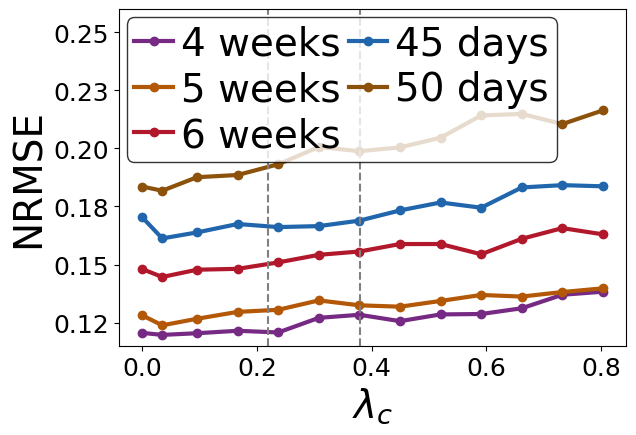

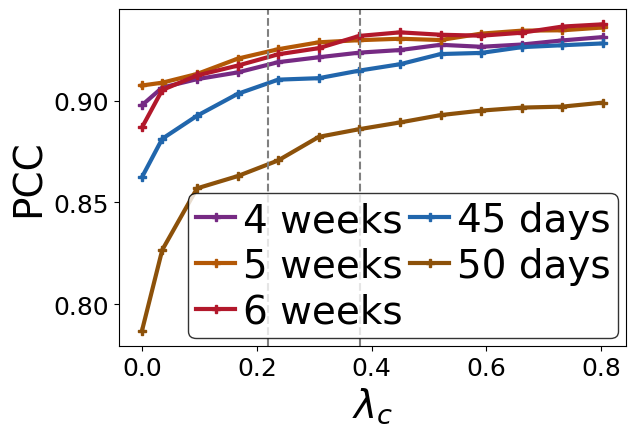

In [62]:
from matplotlib import rcParams
import matplotlib.ticker as ticker

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-10
rcParams["ytick.labelsize"] = max_font_size-10

fig,ax = plt.subplots(figsize=(7,5))

lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
              'ecolor':'black','size':28,'alpha':0.8}

lag_vals = [22,28,34,41,45,51]
lag_labels = ['3 weeks','4 weeks','5 weeks','6 weeks','45 days','50 days']

breaks = 7
thresh = 0.85

color_lags = ['#01665e','#762a83','#b35806','#b2182b','#2166ac','#8c510a']
#['#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e']
#['#c51b7d','#de77ae','#f1b6da','#fde0ef','#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221']
#['#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837']
#['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788']
#['#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac']
#for lidx, lag in enumerate(df['lag'].unique().tolist()):
for lidx, lag in enumerate(lag_vals):
    #if lag<40:
    #    continue
    if lag<28:
        continue
    cur_df = df[(df.lag==lag) & (df.lcorr<=thresh) & (df.model<=2)].sort_values(by='lcorr')
    cur_df = cur_df.groupby('lcorr')[['nrmse','pcc']].mean().reset_index()
    #break
    #cur_df2 = df2[(df2.lag==lag) & (df2.lcorr<=0.1)].sort_values(by='lcorr')
    #print(cur_df.shape[0])
    x = (cur_df['lcorr'].rolling(10,min_periods=1).mean()).tolist()[0::breaks]
    y = ((cur_df['nrmse']/2).rolling(10,min_periods=1).mean()*2).tolist()[0::breaks]
    nrmse_loss = (max(y)-y[0])/y[0]
    z = (cur_df['pcc'].rolling(10,min_periods=1).mean()).tolist()[0::breaks]
    pcc_improv = ((max(z)-z[0])/z[0])
    #if nrmse_loss<pcc_improv:
    if True:
        #print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        print('for lag',lag_labels[lidx],'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        ax.plot(x,y,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='o')
        #ax[0].plot(x,y,label=str(lag),marker='o')
        #ax[1].plot(x,z,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='P')
        #ax[1].plot(x,z,label=str(lag),marker='P')
    
    # cur_df = df2[(df2.lag==lag) & (df2.lcorr<=0.05)].sort_values(by='lcorr')
    # x = (cur_df['lcorr'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # y = (cur_df['nrmse'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # nrmse_loss = (max(y)-y[0])/y[0]
    # z = (cur_df['pcc'].rolling(5,min_periods=1).mean()).tolist()[0::1]
    # pcc_improv = ((max(z)-z[0])/z[0])
    # if True:
    #     print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
    #     ax[0].plot(x,y,label=str(lag)+' 300',marker='o')
    #     ax[1].plot(x,z,label=str(lag)+' 300',marker='P')

ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})

#ax.set_title('Calibrated Model NRMSE')
#ax[0].set_xlim([0,0.3])
ax.set_ylim([None,0.26])
ax.axvline(x=0.22,linestyle='--',color='gray')
ax.axvline(x=0.38,linestyle='--',color='gray')
ax.set_xlabel('${\\lambda_c}$',fontsize=28)
ax.set_ylabel('NRMSE',fontsize=28)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0)
fig.savefig('loss_ablation_rmse.png',dpi=350,bbox_inches='tight')

fig,ax = plt.subplots(figsize=(7,5))

#lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
#              'ecolor':'black','size':32,'alpha':0.2}

lag_vals = [22,28,34,41,45,51]
lag_labels = ['3 weeks','4 weeks','5 weeks','6 weeks','45 days','50 days']

color_lags = ['#01665e','#762a83','#b35806','#b2182b','#2166ac','#8c510a']
#['#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e']
#['#c51b7d','#de77ae','#f1b6da','#fde0ef','#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221']
#['#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837']
#['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788']
#['#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac']
#for lidx, lag in enumerate(df['lag'].unique().tolist()):
for lidx, lag in enumerate(lag_vals):
    #if lag<40:
    #    continue
    if lag<28:
        continue
    cur_df = df[(df.lag==lag) & (df.lcorr<=thresh) & (df.model<=2)].sort_values(by='lcorr')
    cur_df = cur_df.groupby('lcorr')[['nrmse','pcc']].mean().reset_index()
    #break
    #cur_df2 = df2[(df2.lag==lag) & (df2.lcorr<=0.1)].sort_values(by='lcorr')
    #print(cur_df.shape[0])
    x = (cur_df['lcorr'].rolling(10,min_periods=1).mean()).tolist()[0::breaks]
    y = ((cur_df['nrmse']/2).rolling(10,min_periods=1).mean()*2).tolist()[0::breaks]
    nrmse_loss = (max(y)-y[0])/y[0]
    z = (cur_df['pcc'].rolling(10,min_periods=1).mean()).tolist()[0::breaks]
    pcc_improv = ((max(z)-z[0])/z[0])
    #if nrmse_loss<pcc_improv:
    if True:
        #print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        print('for lag',lag_labels[lidx],'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        #ax.plot(x,y,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='o')
        #ax[0].plot(x,y,label=str(lag),marker='o')
        ax.plot(x,z,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='P')
        #ax[1].plot(x,z,label=str(lag),marker='P')
    
    # cur_df = df2[(df2.lag==lag) & (df2.lcorr<=0.05)].sort_values(by='lcorr')
    # x = (cur_df['lcorr'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # y = (cur_df['nrmse'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # nrmse_loss = (max(y)-y[0])/y[0]
    # z = (cur_df['pcc'].rolling(5,min_periods=1).mean()).tolist()[0::1]
    # pcc_improv = ((max(z)-z[0])/z[0])
    # if True:
    #     print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
    #     ax[0].plot(x,y,label=str(lag)+' 300',marker='o')
    #     ax[1].plot(x,z,label=str(lag)+' 300',marker='P')

ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})

#ax.set_title('Calibrated Model PCC')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set_xlabel('${\\lambda_c}$',fontsize=28)
ax.set_ylabel('PCC',fontsize=28)
ax.axvline(x=0.22,linestyle='--',color='gray')
ax.axvline(x=0.38,linestyle='--',color='gray')
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0)
fig.savefig('loss_ablation_corr.png',dpi=350,bbox_inches='tight')

In [39]:
lcorr_list = df['lcorr'].unique().tolist()
lcorr_list.sort()
for lcorr_thresh in lcorr_list:
    print(lcorr_thresh)
    for lidx, lag in enumerate(lag_vals):
        if lag<28:
            continue
        cur_df = df[(df.lag==lag) & (df.lcorr<=lcorr_thresh) & (df.model<=2)].sort_values(by='lcorr')
        cur_df = cur_df.groupby('lcorr')[['nrmse','pcc']].mean().reset_index()
        x = (cur_df['lcorr'].rolling(10,min_periods=1).mean()).tolist()[0::2]
        y = ((cur_df['nrmse']/2).rolling(10,min_periods=1).mean()*2).tolist()[0::2]
        nrmse_loss = (max(y)-y[0])/y[0]
        z = (cur_df['pcc'].rolling(10,min_periods=1).mean()).tolist()[0::2]
        pcc_improv = ((max(z)-z[0])/z[0])
        if True:
            print('for lag',lag_labels[lidx],'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        

0.0
for lag 4 weeks adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 5 weeks adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 6 weeks adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 45 days adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 50 days adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
0.010101010101010102
for lag 4 weeks adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 5 weeks adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 6 weeks adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 0.0 percent
for lag 45 days adding some weight to PCC impro

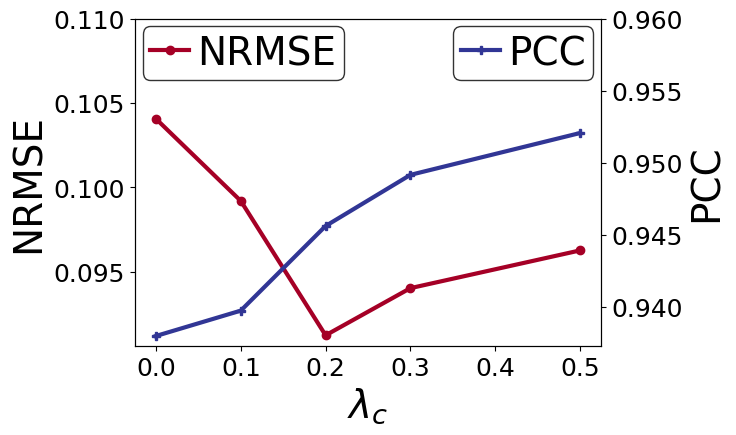

In [61]:
from matplotlib import rcParams
import matplotlib.ticker as ticker

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-10
rcParams["ytick.labelsize"] = max_font_size-10

fig,ax = plt.subplots(figsize=(8,5))

lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
              'ecolor':'black','size':28,'alpha':0.8}

lcorrs = [0.0,0.1,0.2,0.3,0.5]
rmses = [0.1040567787,0.09919429194,0.09123521668,0.09402826409,0.09626298873]
pccs = [0.9379671846,0.9397264768,0.9455998316,0.949147804,0.95205138]

ax.plot(lcorrs,rmses,color='#a50026',linewidth=3,marker='o',label='NRMSE')

ax.legend(loc="upper left", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})

#ax.axvline(x=0.22,linestyle='--',color='gray')
#ax.axvline(x=0.38,linestyle='--',color='gray')
ax.set_xlabel('${\\lambda_c}$',fontsize=28)
ax.set_ylim([None,0.11])
ax.set_ylabel('NRMSE',fontsize=28)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.12, hspace=0)
#fig.savefig('loss_ablation_abm_rmse.png',dpi=350,bbox_inches='tight')

#fig,ax = plt.subplots(figsize=(7,5))

#lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
#              'ecolor':'black','size':32,'alpha':0.2}
ax2 = ax.twinx()
ax2.plot(lcorrs,pccs,color='#313695',linewidth=3,marker='P',label='PCC')

ax2.legend(loc="upper right", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})

#ax.set_title('Calibrated Model PCC')
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax2.set_xlabel('${\\lambda_c}$',fontsize=28)
ax2.set_ylabel('PCC',fontsize=28)
ax2.set_ylim([None,0.96])
#ax.axvline(x=0.22,linestyle='--',color='gray')
#ax.axvline(x=0.38,linestyle='--',color='gray')
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0)
fig.savefig('loss_ablation_abm.png',dpi=350,bbox_inches='tight')

for lag 4 weeks adding some weight to PCC improves PCC by 1.33 percent while hurting accuracy by at most 20.43 percent
for lag 5 weeks adding some weight to PCC improves PCC by 0.21 percent while hurting accuracy by at most 33.72 percent
for lag 6 weeks adding some weight to PCC improves PCC by 1.45 percent while hurting accuracy by at most 42.21 percent
for lag 45 days adding some weight to PCC improves PCC by 1.26 percent while hurting accuracy by at most 41.29 percent
for lag 50 days adding some weight to PCC improves PCC by 5.05 percent while hurting accuracy by at most 48.09 percent


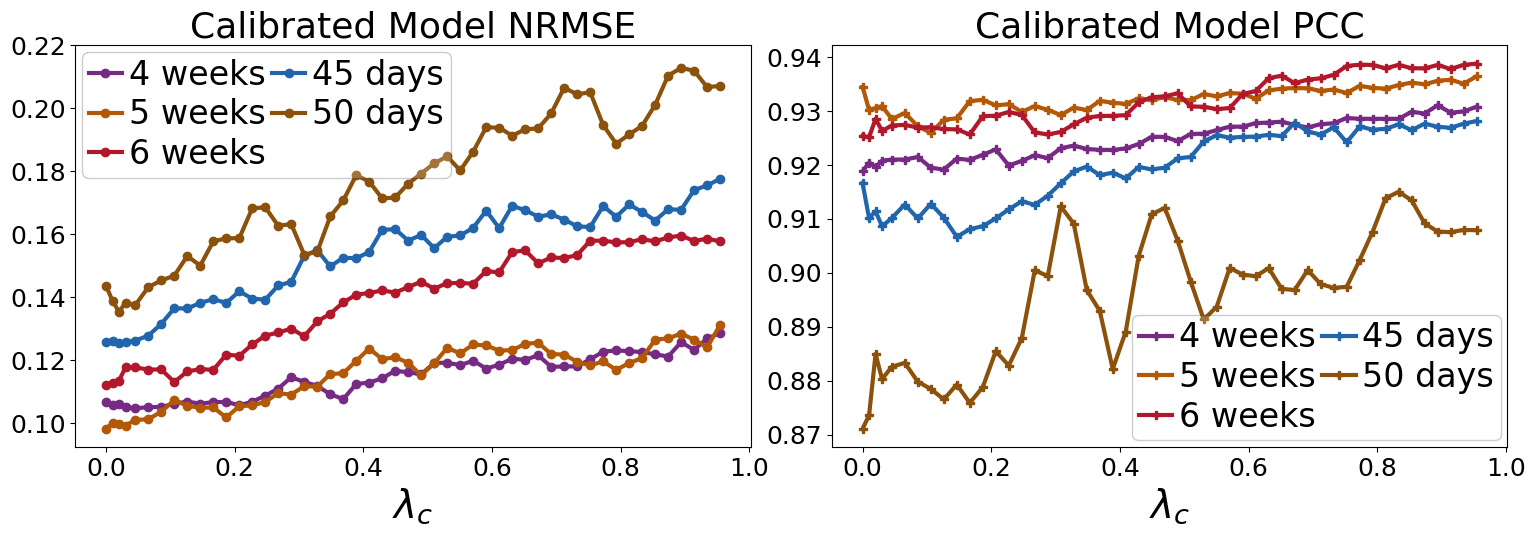

In [17]:
from matplotlib import rcParams

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-10
rcParams["ytick.labelsize"] = max_font_size-10

fig,ax = plt.subplots(1,2,figsize=(16,6))

lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
              'ecolor':'black','size':24,'alpha':0.2}

lag_vals = [22,28,34,41,45,51]
lag_labels = ['3 weeks','4 weeks','5 weeks','6 weeks','45 days','50 days']

color_lags = ['#01665e','#762a83','#b35806','#b2182b','#2166ac','#8c510a']
#['#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e']
#['#c51b7d','#de77ae','#f1b6da','#fde0ef','#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221']
#['#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837']
#['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788']
#['#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac']
#for lidx, lag in enumerate(df['lag'].unique().tolist()):
for lidx, lag in enumerate(lag_vals):
    #if lag<40:
    #    continue
    if lag<28:
        continue
    cur_df = df[(df.lag==lag) & (df.lcorr<=1) & (df.model<=2)].sort_values(by='lcorr')
    cur_df = cur_df.groupby('lcorr')[['nrmse','pcc']].mean().reset_index()
    #break
    #cur_df2 = df2[(df2.lag==lag) & (df2.lcorr<=0.1)].sort_values(by='lcorr')
    #print(cur_df.shape[0])
    x = (cur_df['lcorr'].rolling(8,min_periods=1).mean()).tolist()[0::2]
    y = ((cur_df['nrmse']/2).rolling(8,min_periods=1).mean()*2).tolist()[0::2]
    nrmse_loss = (max(y)-y[0])/y[0]
    z = (cur_df['pcc'].rolling(8,min_periods=1).mean()).tolist()[0::2]
    pcc_improv = ((max(z)-z[0])/z[0])
    #if nrmse_loss<pcc_improv:
    if True:
        #print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        print('for lag',lag_labels[lidx],'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        ax[0].plot(x,y,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='o')
        #ax[0].plot(x,y,label=str(lag),marker='o')
        ax[1].plot(x,z,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='P')
        #ax[1].plot(x,z,label=str(lag),marker='P')
    
    # cur_df = df2[(df2.lag==lag) & (df2.lcorr<=0.05)].sort_values(by='lcorr')
    # x = (cur_df['lcorr'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # y = (cur_df['nrmse'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # nrmse_loss = (max(y)-y[0])/y[0]
    # z = (cur_df['pcc'].rolling(5,min_periods=1).mean()).tolist()[0::1]
    # pcc_improv = ((max(z)-z[0])/z[0])
    # if True:
    #     print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
    #     ax[0].plot(x,y,label=str(lag)+' 300',marker='o')
    #     ax[1].plot(x,z,label=str(lag)+' 300',marker='P')

ax[0].legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})
ax[1].legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
             prop={'size': lgd_params['size']})
ax[0].set_title('Calibrated Model NRMSE')
#ax[0].set_xlim([0,0.3])
ax[0].set_ylim([None,0.22])
ax[1].set_title('Calibrated Model PCC')
ax[0].set_xlabel('${\\lambda_c}$',fontsize=28)
ax[1].set_xlabel('${\\lambda_c}$',fontsize=28)
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0)
#fig.savefig('loss_ablation.png',dpi=350,bbox_inches='tight')

for lag 22 adding some weight to PCC improves PCC by 0.15 percent while hurting accuracy by at most 0.82 percent
for lag 28 adding some weight to PCC improves PCC by 0.0 percent while hurting accuracy by at most 1.22 percent
for lag 34 adding some weight to PCC improves PCC by 0.13 percent while hurting accuracy by at most 2.53 percent
for lag 41 adding some weight to PCC improves PCC by 2.87 percent while hurting accuracy by at most 0.0 percent
for lag 45 adding some weight to PCC improves PCC by 1.47 percent while hurting accuracy by at most 0.29 percent
for lag 51 adding some weight to PCC improves PCC by 2.3 percent while hurting accuracy by at most 0.19 percent


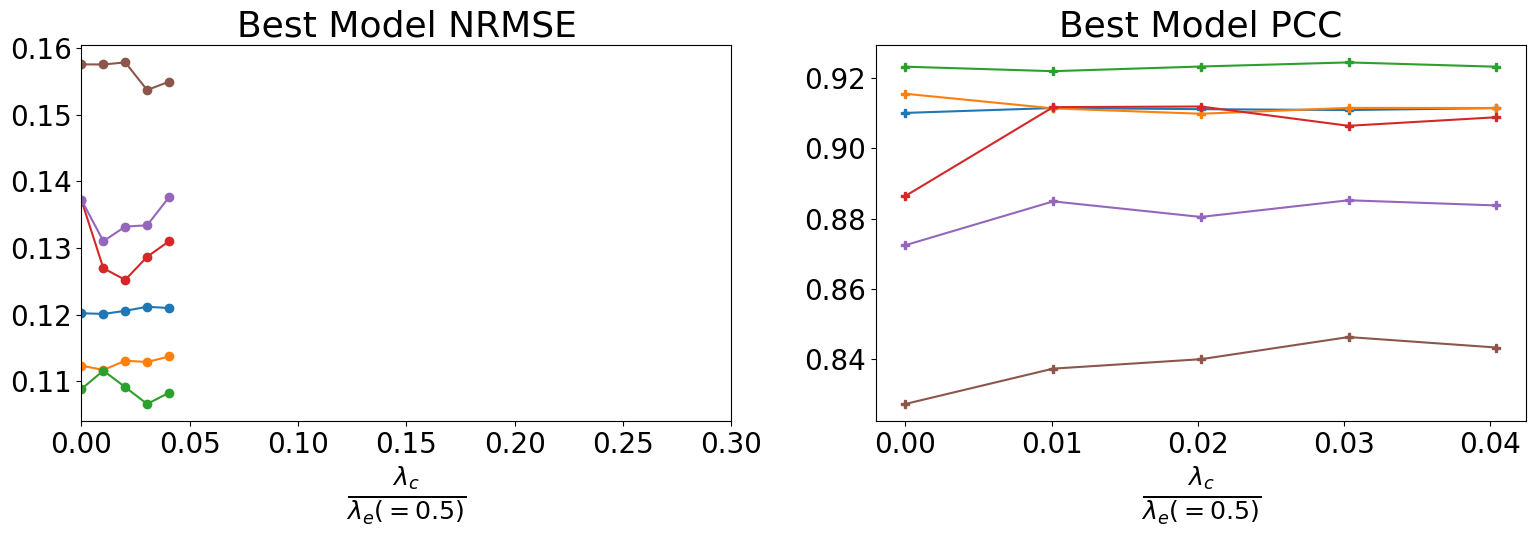

In [25]:
from matplotlib import rcParams

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8

fig,ax = plt.subplots(1,2,figsize=(16,6))

lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,
              'ecolor':'black','size':24,'alpha':0.2}

lag_vals = [22,28,34,41,45,51]
lag_labels = ['3 weeks','4 weeks','5 weeks','6 weeks','45 days','50 days']

color_lags = ['#01665e','#762a83','#b35806','#b2182b','#2166ac','#8c510a']
#['#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e']
#['#c51b7d','#de77ae','#f1b6da','#fde0ef','#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221']
#['#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837']
#['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788']
#['#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac']
#for lidx, lag in enumerate(df['lag'].unique().tolist()):
for lidx, lag in enumerate(lag_vals):
    #if lag<40:
    #    continue
    #if lag<28:
    #    continue
    cur_df = df[(df.lag==lag) & (df.lcorr<=0.05) & (df.model<=2)].sort_values(by='lcorr')
    cur_df = cur_df.groupby('lcorr')[['nrmse','pcc']].mean().reset_index()
    #break
    #cur_df2 = df2[(df2.lag==lag) & (df2.lcorr<=0.1)].sort_values(by='lcorr')
    #print(cur_df.shape[0])
    x = (cur_df['lcorr'].rolling(21,min_periods=1).mean()*2).tolist()[0::1]
    y = ((cur_df['nrmse']/2).rolling(21,min_periods=1).mean()*2).tolist()[0::1]
    nrmse_loss = (max(y)-y[0])/y[0]
    z = (cur_df['pcc'].rolling(5,min_periods=1).mean()).tolist()[0::1]
    pcc_improv = ((max(z)-z[0])/z[0])
    #if nrmse_loss<pcc_improv:
    if True:
        print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        #print('for lag',lag_labels[lidx],'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
        #ax[0].plot(x,y,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='o')
        ax[0].plot(x,y,label=str(lag),marker='o')
        #ax[1].plot(x,z,label=lag_labels[lidx],color=color_lags[lidx],linewidth=3,marker='P')
        ax[1].plot(x,z,label=str(lag),marker='P')
    
    # cur_df = df2[(df2.lag==lag) & (df2.lcorr<=0.05)].sort_values(by='lcorr')
    # x = (cur_df['lcorr'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # y = (cur_df['nrmse'].rolling(5,min_periods=1).mean()*2).tolist()[0::1]
    # nrmse_loss = (max(y)-y[0])/y[0]
    # z = (cur_df['pcc'].rolling(5,min_periods=1).mean()).tolist()[0::1]
    # pcc_improv = ((max(z)-z[0])/z[0])
    # if True:
    #     print('for lag',lag,'adding some weight to PCC improves PCC by',round(pcc_improv*100,2),'percent while hurting accuracy by at most',round(nrmse_loss*100,2),'percent')
    #     ax[0].plot(x,y,label=str(lag)+' 300',marker='o')
    #     ax[1].plot(x,z,label=str(lag)+' 300',marker='P')

#ax[0].legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
#              handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
#              ncol=1, edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
#              prop={'size': lgd_params['size']})
#ax[1].legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
#             handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
#             ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
#             prop={'size': lgd_params['size']})
ax[0].set_title('Best Model NRMSE')
ax[0].set_xlim([0,0.3])
ax[1].set_title('Best Model PCC')
ax[0].set_xlabel('$\\frac{\\lambda_c}{\\lambda_e(=0.5)}$')
ax[1].set_xlabel('$\\frac{\\lambda_c}{\\lambda_e(=0.5)}$')
fig.tight_layout()
#fig.savefig('loss_ablation.png',dpi=350,bbox_inches='tight')

In [75]:
0.01/0.5

0.02